# n-widths for transport problems 
## Heaviside step function
$u(x;\mu) = f(x, \mu) = \begin{cases}
    0.0 & \text{if $x < \mu $} \\
    0.5 & \text{if $x = \mu $} \\
    1.0 & \text{if $x > \mu $}
  \end{cases}$ 
  
  $ x \in ({0,1})$ and $ \mu \in ({0,1})$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd, orth, qr
from scipy.optimize import curve_fit
from numpy import sin, cos, pi
cmap = plt.cm.plasma

In [2]:
from initial_conditions import Domain, Heaviside, LinearRamp, SmoothRamp, Sigmoid, CkRamp
from basis_functions import SVD, Trigonometric, Trigonometric2, TrigonometricOdd, Greedy, LNA, LPF, Sinc, Fourier

We need to set some boring plotting options...:

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
page_width_pt = 455.24
pt2in = 0.01389 
pt2cm = 0.0352777778
cm2in = 1/2.54
plot_width_in = page_width_pt*pt2in/2
print(plot_width_in/cm2in)

plt.rcParams["figure.figsize"] = (plot_width_in, plot_width_in/1.61803398875)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
#mpl.rc('text', usetex=True)
mpl.rc('font', family='serif', size=12, serif='Computer Modern Roman')

8.030570172000001


In [4]:
def plot_modes(x, X, r=10):
    for i in range(r):
        print(i, r, i/r)
        plt.plot(x, X[:, i], "o", ms=1, color=cmap(i/(r-1)), label="mode {:.0f}".format(i))
    plt.xlim([0, 1])
    plt.grid(which="both")
    return

def plot_and_compare_modes(x, U1, U2, r=6):
    fig, ax1 = plt.subplots()
    for i in range(r):
        plt.plot(x, U1[:, i], "o", ms=1, color=cmap(i/(r-1)), label="mode {:.0f}".format(i))
    for i in range(r):  # fix z-order
        plt.plot(x, U2[:, i], "k--")
    plt.xlim([0, 1])
    plt.grid(which="both")
    plt.show()
    return

def plot_singular_values(S):
    S = S/S[0].copy()  # normalize singular values to make for a better comparison!
    fig, ax1 = plt.subplots()
    ax1.plot(np.arange(1, len(S)+1), S, "k.", ms=1)
    ax1.set_xlabel("order")
    ax1.set_ylabel("singular value")
    ax1.set_yscale('log')
    ax1.set_xlim([0, len(S)])
#    ax1.set_ylim([1e-6, 100])
    ax1.grid(which="both")
    plt.tight_layout()
    plt.show()
    return fig, ax1

def plot_error(rms_error, max_error):
    fig, ax = plt.subplots()
    ax.plot(max_error, ".", label="max_error")
    ax.plot(rms_error, ".", label="rms_error")
    ax.set_yscale('log')
    plt.legend(prop={'size': 8})
    return fig, ax

def plot_paramspace(X):
    fig, ax = plt.subplots()
    plt.imshow(X, interpolation="none")
    ax.set_xlabel("$\mu$")
    ax.set_ylabel("$x$")
    plt.show()
    return fig, ax

def save_im(res, name):
    print(res.min(), res.max())
    fig, ax = plt.subplots()
    cs = plt.imshow(res, interpolation="nearest", origin="upper")
    plt.colorbar(cs)
    a = np.round(cmap(res/2+0.5)*256, decimals=0)
    img = np.array(a-1, dtype=np.uint8)
    from PIL import Image
    im = Image.fromarray(img)
    im.save(name+'.png')
    plt.close()

In [5]:
def sort_trig_basis(trig_basis_odd, X):
    V_k = trig_basis_odd.U.reshape(m, -1, 2)  # x, r, 2
    V_1 = V_k[:, :, 0].copy()  # sin
    c = V_1.T @ X  # V_1.T @ X is slow!
    c_n = (c**2).sum(axis=1)
    order = np.argsort(-c_n)
    trig_basis_odd.U = V_k[:, order, :].reshape(m, -1)
    trig_basis_odd.frequencies = trig_basis_odd.frequencies[order]
    return None


def SVD_vs_trig_basis(svd_basis, trig_basis_odd):
    # correlation matrix
    cm = trig_basis_odd.U.T @ svd_basis.U  # (n, m) (m, r) = n, r
    frequencies = trig_basis_odd.frequencies
    x = trig_basis_odd.x
    A = trig_basis_odd.A
    m, r = trig_basis_odd.U.shape
    e = np.zeros(r,)

    for i in range(m//2):  # m//2
        SVD_psi_1 = svd_basis.U[:, 2*i]
        SVD_psi_2 = svd_basis.U[:, 2*i+1]
        f1 = f2 = frequencies[i]
        # c1 and c2 are equal, unless th sign of the SVD is flipped.
        # A flipped sign looks like a phase shift by +- pi
        # we dont know when that happens, we just compute a new c 
        cos_c1 = cm[2*i, 2*i]  # n, r
        sin_c1 = -cm[2*i+1, 2*i]
        sin_c2 = cm[2*i, 2*i+1]
        cos_c2 = cm[2*i+1, 2*i+1]

        c1 = np.arctan2(sin_c1, cos_c1)
        psi_1 = A*np.sin(2*np.pi*f1*x-c1)

        c2 = np.arctan2(sin_c2, cos_c2)
        psi_2 = A*np.cos(2*np.pi*f2*x-c2)

        e[2*i] = ((SVD_psi_1-psi_1)**2).sum()**.5
        e[2*i+1] = ((SVD_psi_2-psi_2)**2).sum()**.5
    return e

In [6]:
m, n, r = 2500, 2500, 2500
x = Domain([0, 1], m)
mu = Domain([0, 1], n)

In [7]:
#initc = [u_hs, u_lr, u_sr, u_C1, u_C2, u_C3, u_C4, u_C5, u_sg]
#basis = [svd_basis, trig_basis, greedy_basis, lna_basis, lpf_basis]
# 9 ic
# 5 bv
# 4 errors
# r entries

results = np.zeros((6, 9, 4, r))
epsilon = 0.025
u_hs = Heaviside()
u_C0 = CkRamp(epsilon, 0)
u_C1 = CkRamp(epsilon, 1)
u_C2 = CkRamp(epsilon, 2)
u_C3 = CkRamp(epsilon, 3)
u_C4 = CkRamp(epsilon, 4)
u_C5 = CkRamp(epsilon, 5)
u_sg = Sigmoid(epsilon)

initc = [u_C0, u_C1, u_C2, u_C3, u_C4, u_C5, u_sg]
tt = np.linspace(0, 1, 10000)
for j, u_k in enumerate(initc[1:]):  # 9
    print(u_k.name)
    u_k.fit_to(u_C0, tt)

smooth ramp, C^1
mu_test =  0.5000500050005001
epsilon =  0.03316168328741189
cov =  [[7.34920826e-10]]
smooth ramp, C^2
mu_test =  0.5000500050005001
epsilon =  0.04001922754234522
cov =  [[1.92915843e-09]]
smooth ramp, C^3
mu_test =  0.5000500050005001
epsilon =  0.04591862571115181
cov =  [[3.22181004e-09]]
smooth ramp, C^4
mu_test =  0.5000500050005001
epsilon =  0.05116043398053234
cov =  [[4.55007091e-09]]
smooth ramp, C^5
mu_test =  0.5000500050005001
epsilon =  0.0559208586827702
cov =  [[5.89521541e-09]]
sigmoid (sin)
mu_test =  0.5000500050005001
epsilon =  0.019789519904034873
cov =  [[1.19085129e-09]]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman


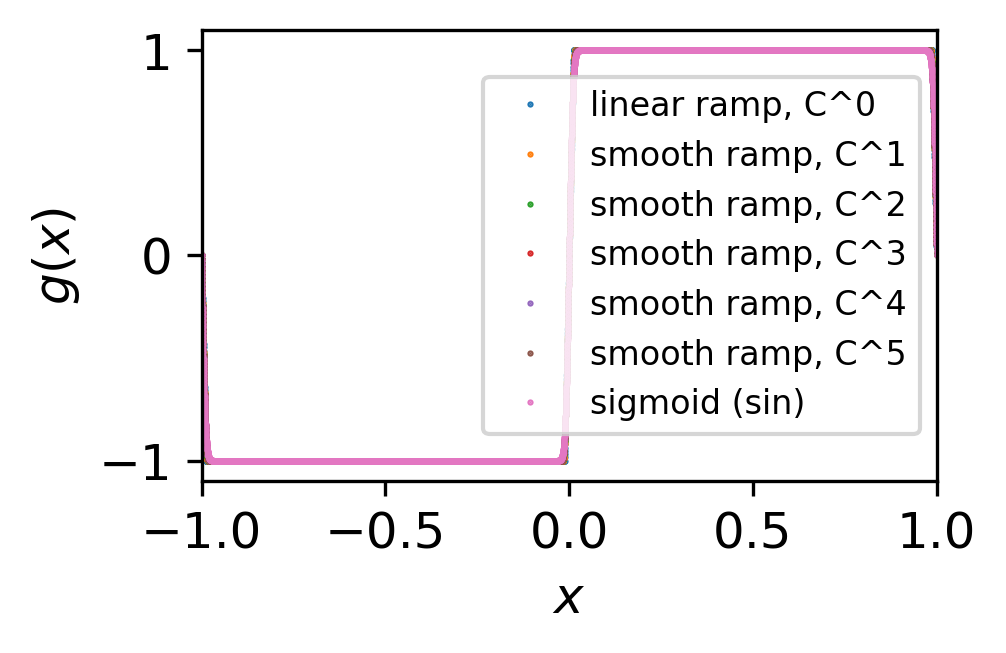

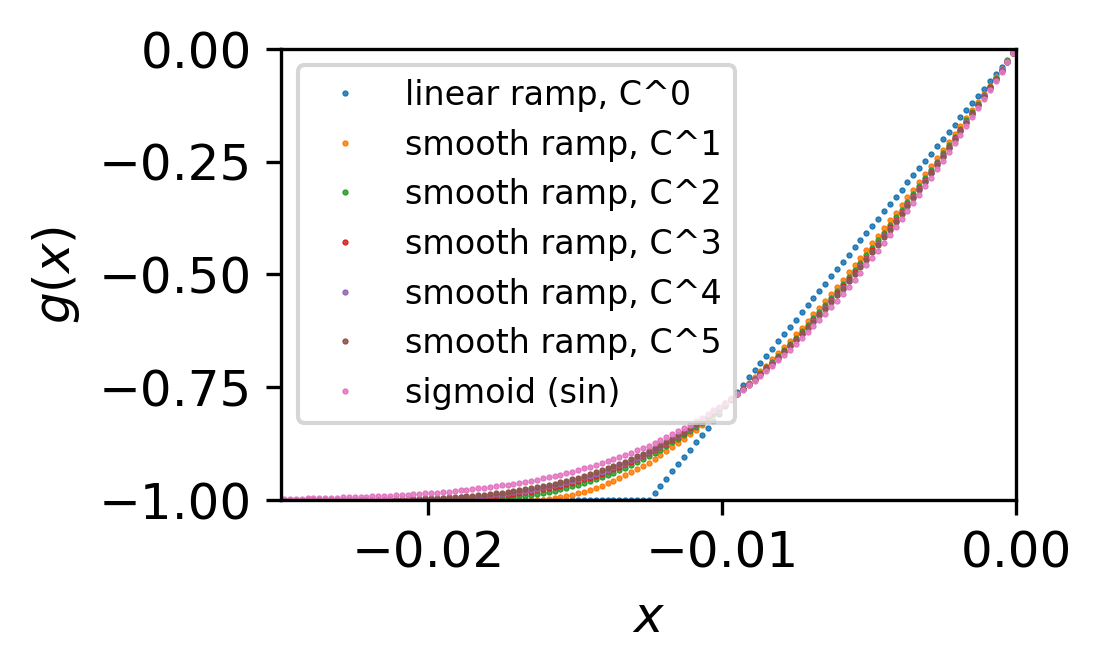

In [8]:
fig, ax = plt.subplots()
for i, ic in enumerate(initc):
    ic.plot(x(), ax=ax, ms=1, label=ic.name)
plt.xlim(-1, 1)
plt.legend(prop={'size': 8})
plt.show()


fig, ax = plt.subplots()
for i, ic in enumerate(initc):
    ic.plot(x(), ax=ax, ms=1, label=ic.name)
plt.xlim(-.025, 0)
plt.ylim(-1, -.0)
plt.legend(prop={'size': 8})
plt.show()

linear ramp, C^0
mu_test =  0.5000500050005001
epsilon =  0.025
cov =  [[0.]]
sorted.
SVD'ed.


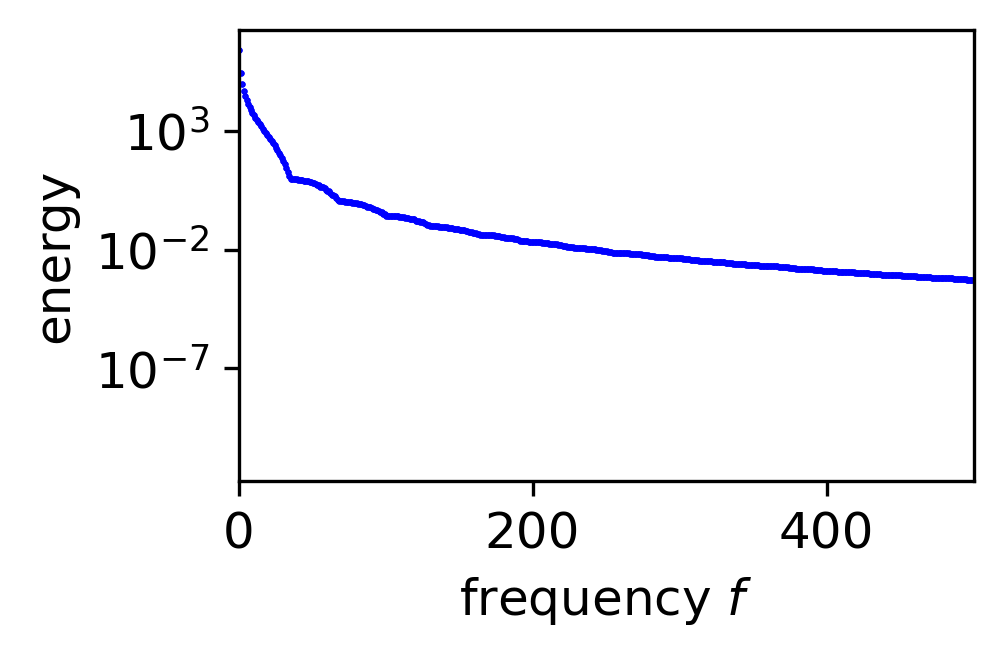

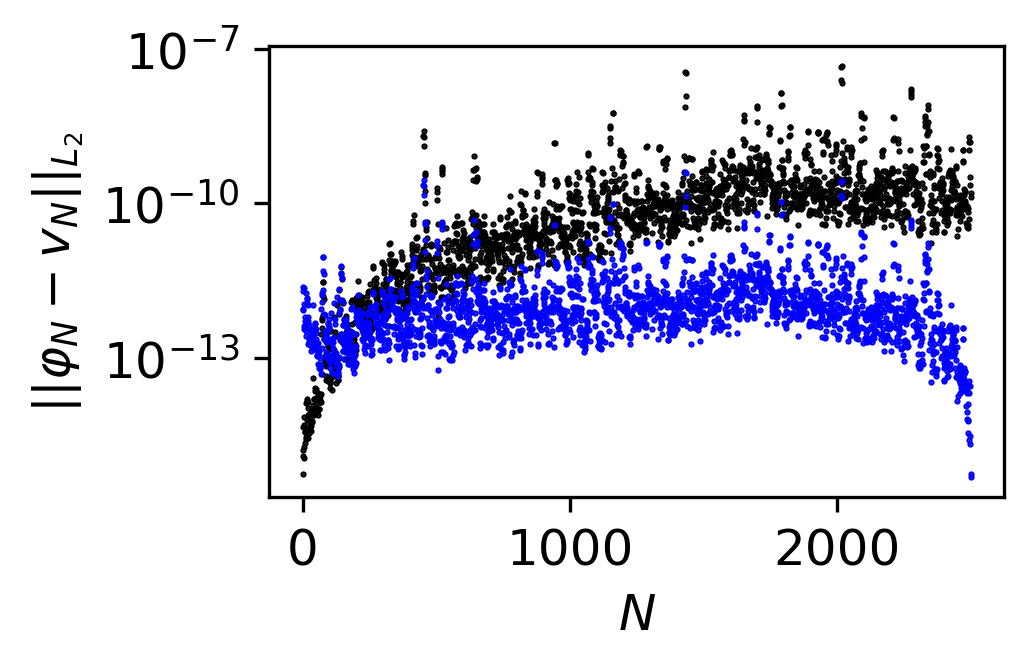

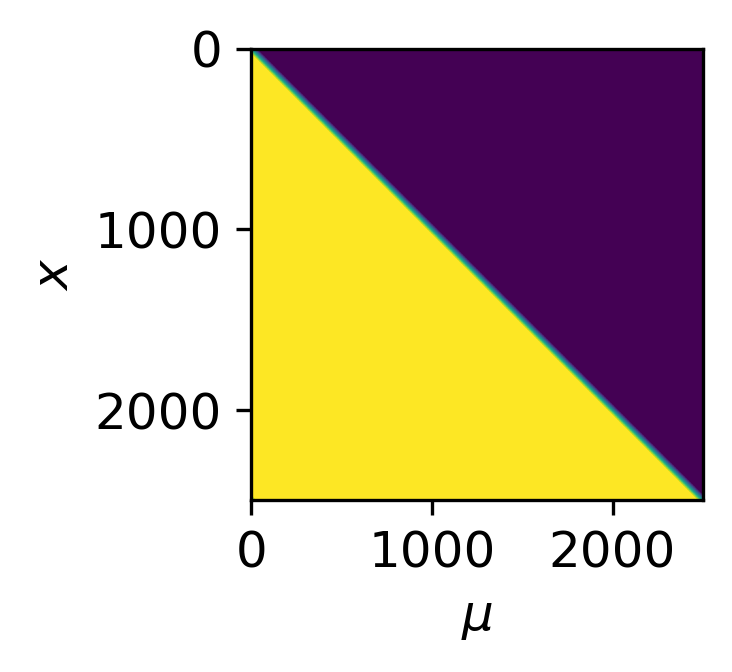

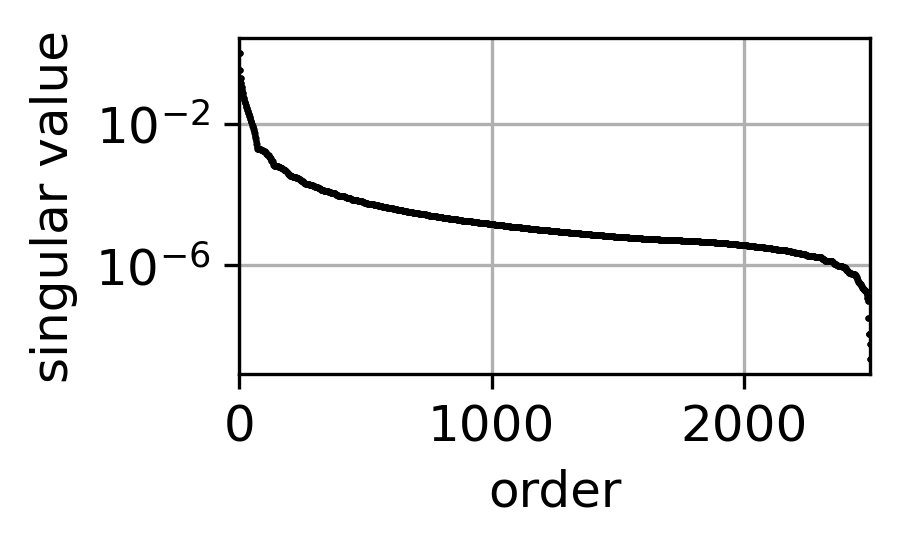

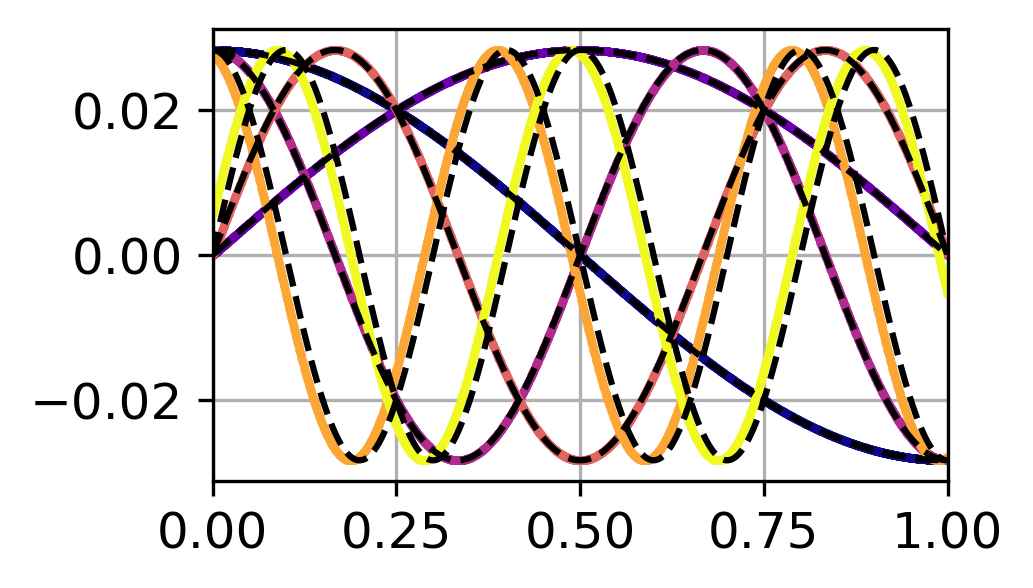

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman


0 6 0.0
1 6 0.16666666666666666
2 6 0.3333333333333333
3 6 0.5
4 6 0.6666666666666666
5 6 0.8333333333333334


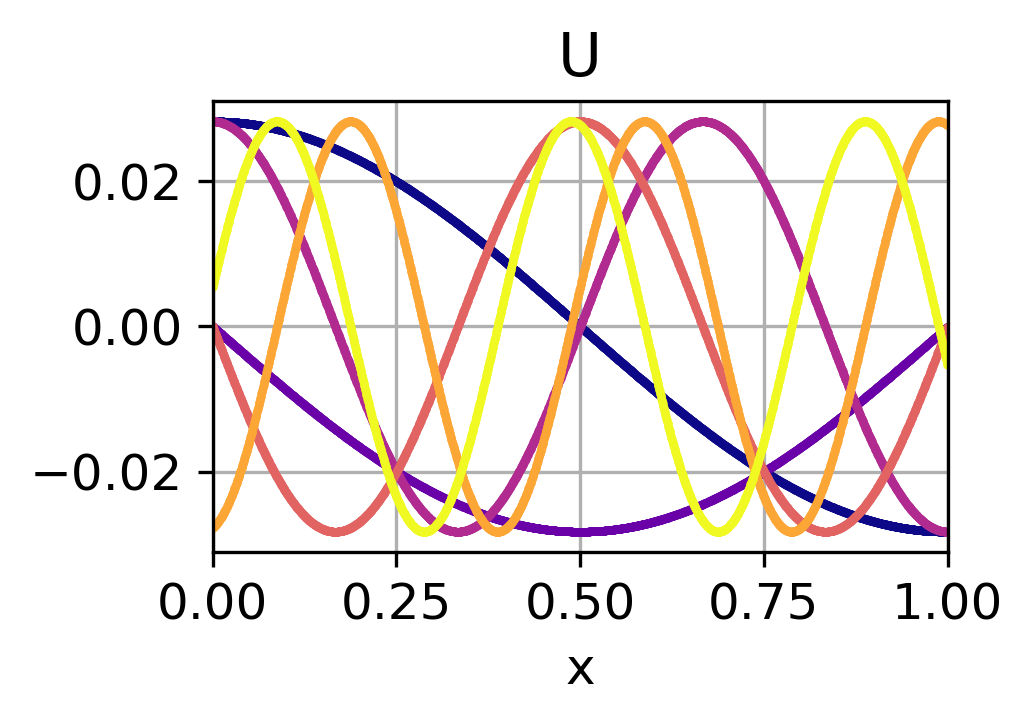

0 6 0.0
1 6 0.16666666666666666
2 6 0.3333333333333333
3 6 0.5
4 6 0.6666666666666666
5 6 0.8333333333333334


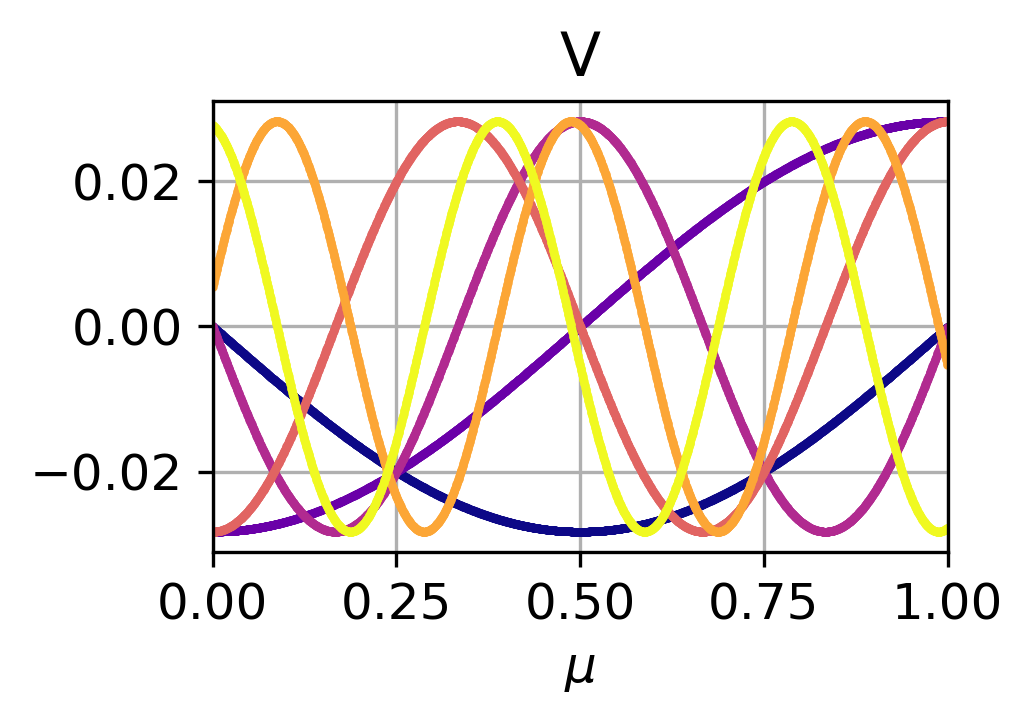

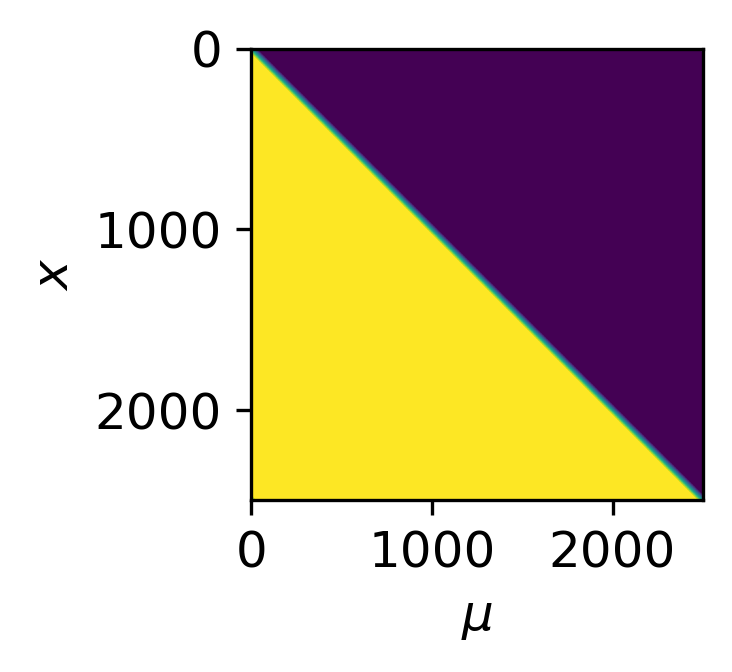

svd
calc_error: 2500 2500 2500
1, 26, 51, 76, 101, 126, 151, 176, 201, 226, 251, 276, 301, 326, 351, 376, 401, 426, 451, 476, 501, 526, 551, 576, 601, 626, 651, 676, 701, 726, 751, 776, 801, 826, 851, 876, 901, 926, 951, 976, 1001, 1026, 1051, 1076, 1101, 1126, 1151, 1176, 1201, 1226, 1251, 1276, 1301, 1326, 1351, 1376, 1401, 1426, 1451, 1476, 1501, 1526, 1551, 1576, 1601, 1626, 1651, 1676, 1701, 1726, 1751, 1776, 1801, 1826, 1851, 1876, 1901, 1926, 1951, 1976, 2001, 2026, 2051, 2076, 2101, 2126, 2151, 2176, 2201, 2226, 2251, 2276, 2301, 2326, 2351, 2376, 2401, 2426, 2451, 2476, 


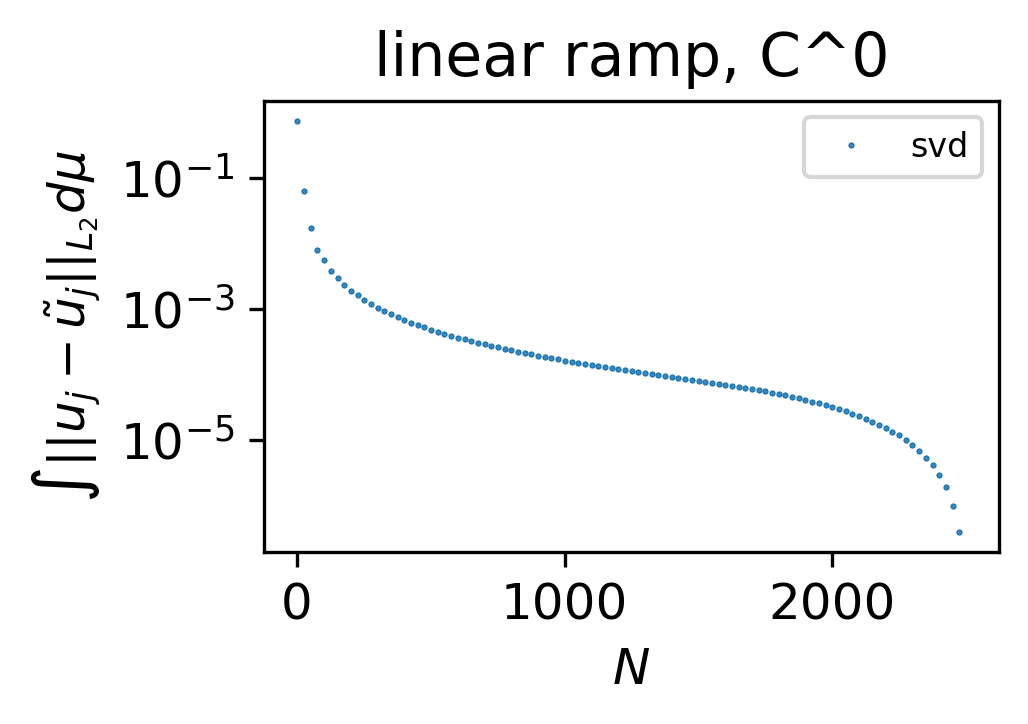

smooth ramp, C^1
mu_test =  0.5000500050005001
epsilon =  0.03316168328741189
cov =  [[7.34920826e-10]]
sorted.
SVD'ed.


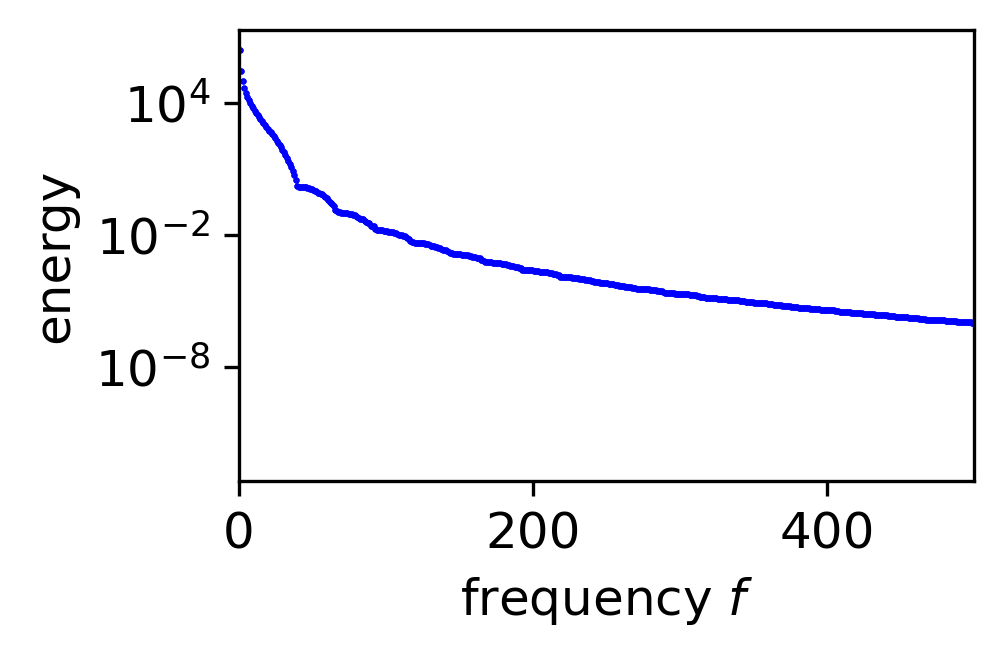

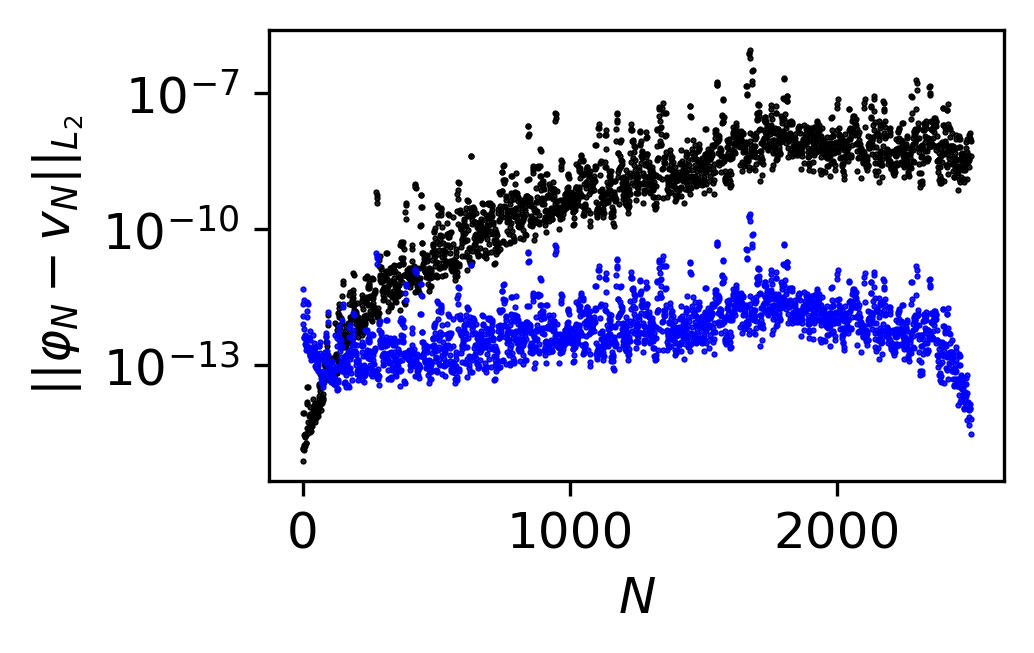

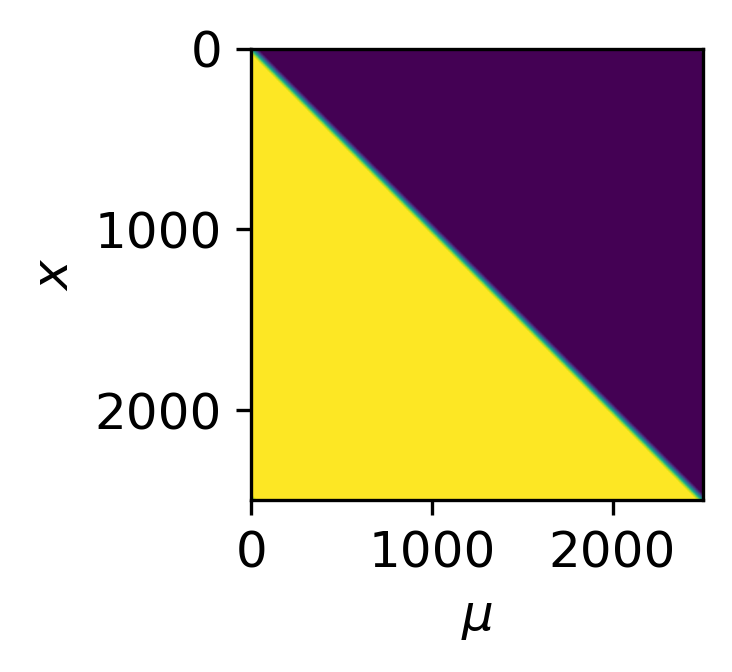

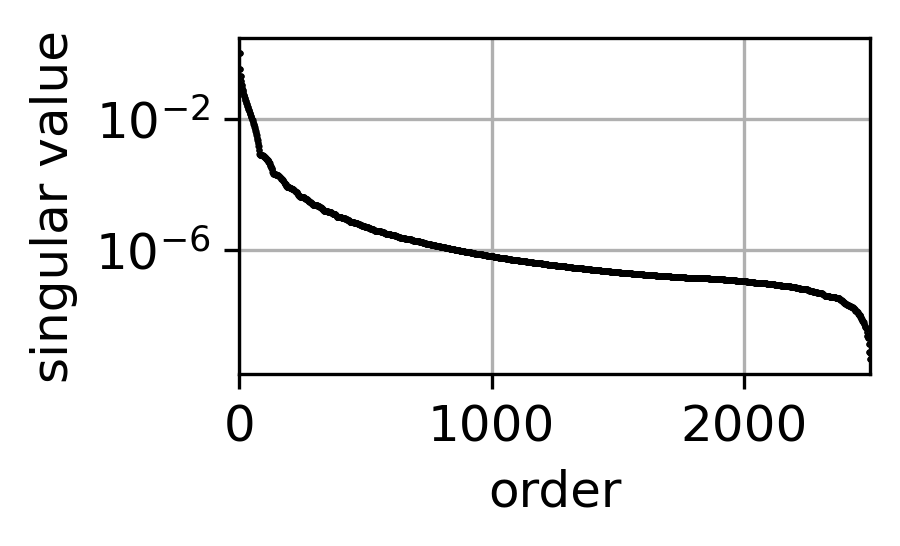

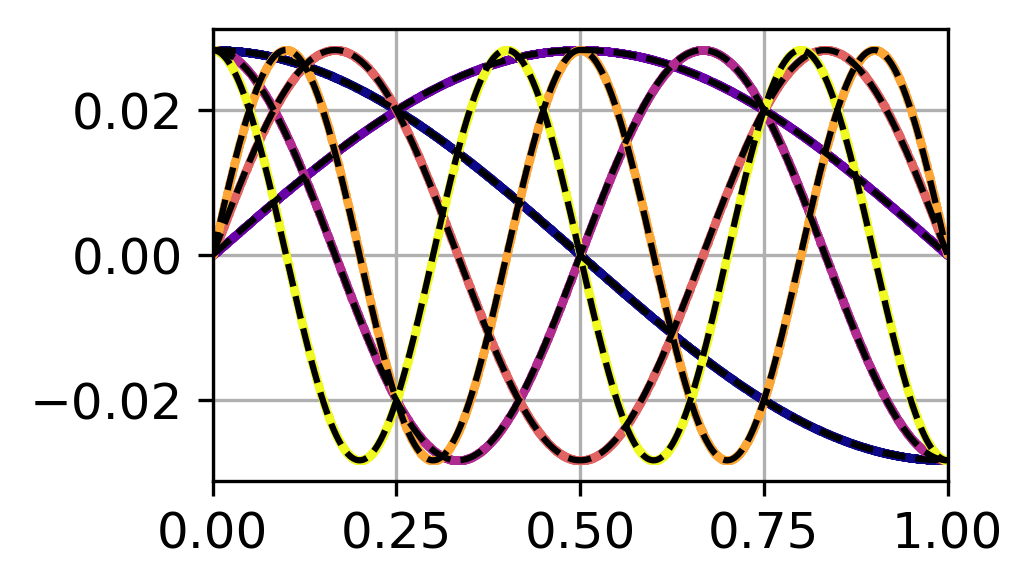

0 6 0.0
1 6 0.16666666666666666
2 6 0.3333333333333333
3 6 0.5
4 6 0.6666666666666666
5 6 0.8333333333333334


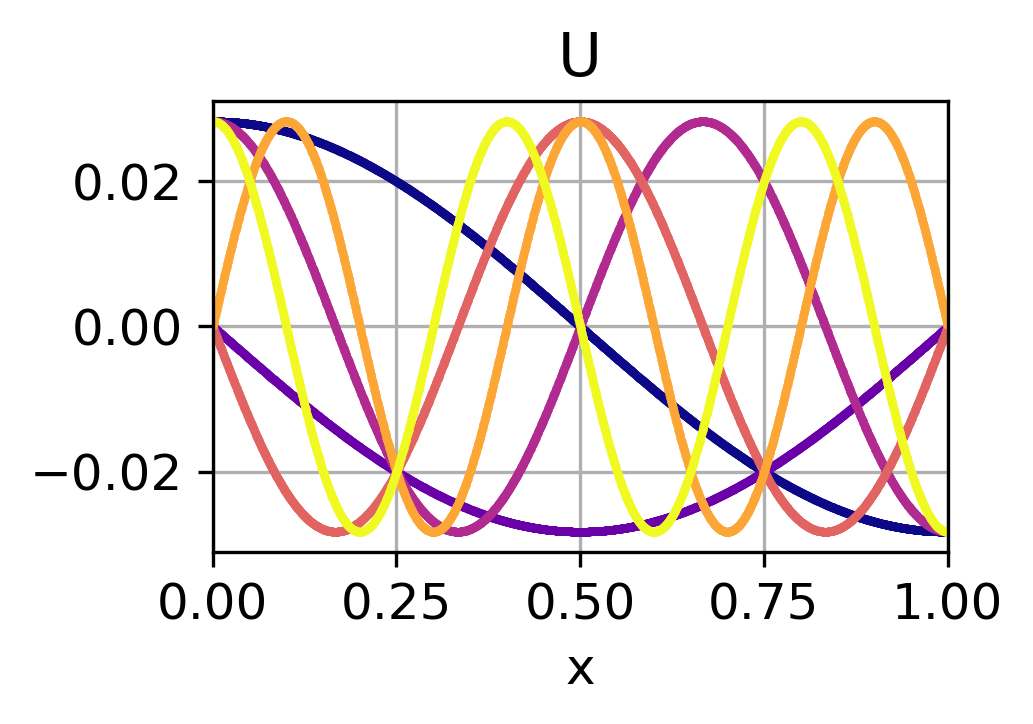

0 6 0.0
1 6 0.16666666666666666
2 6 0.3333333333333333
3 6 0.5
4 6 0.6666666666666666
5 6 0.8333333333333334


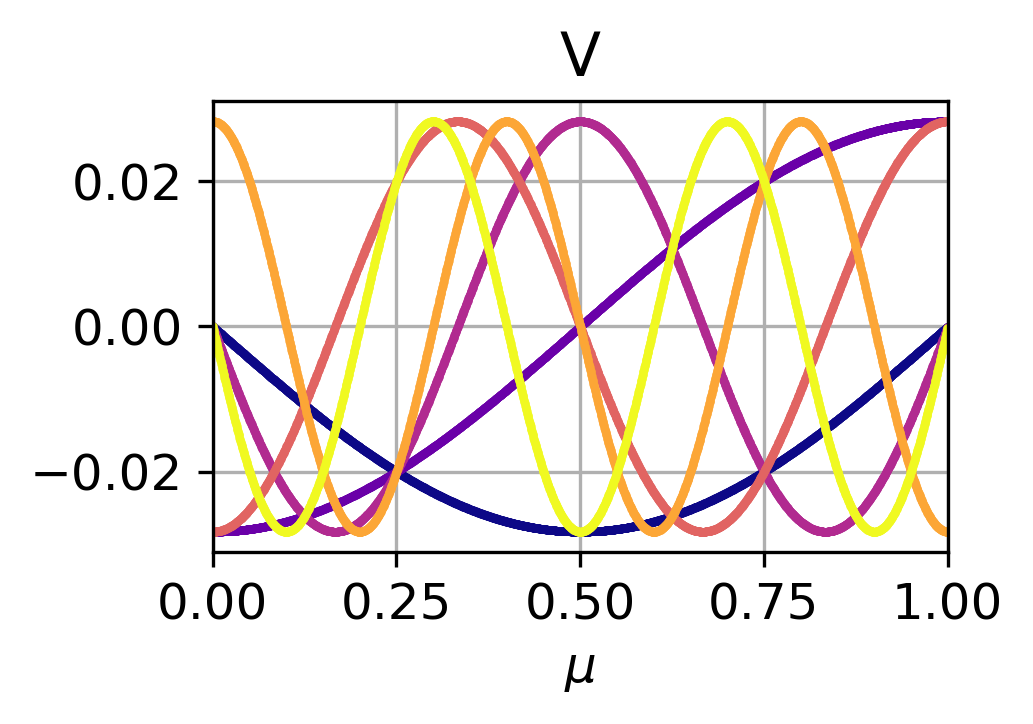

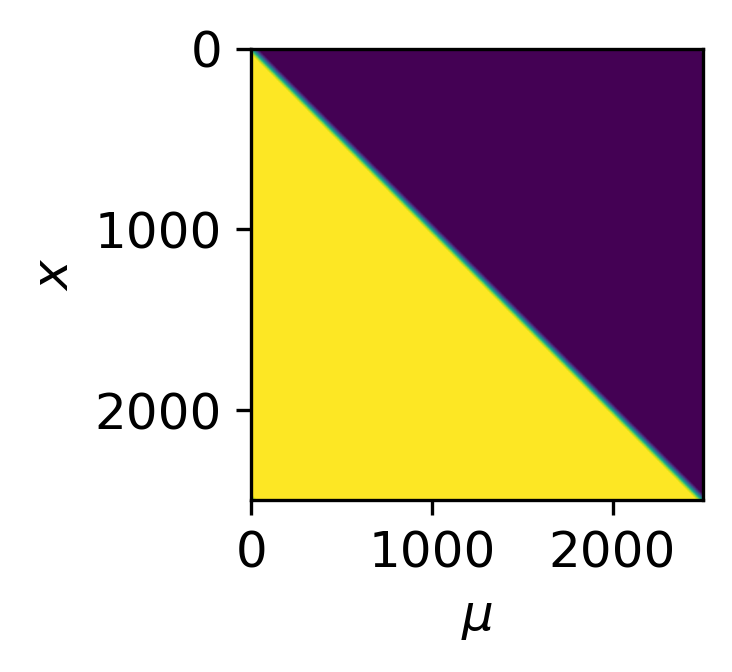

svd
calc_error: 2500 2500 2500
1, 26, 51, 76, 101, 126, 151, 176, 201, 226, 251, 276, 301, 326, 351, 376, 401, 426, 451, 476, 501, 526, 551, 576, 601, 626, 651, 676, 701, 726, 751, 776, 801, 826, 851, 876, 901, 926, 951, 976, 1001, 1026, 1051, 1076, 1101, 1126, 1151, 1176, 1201, 1226, 1251, 1276, 1301, 1326, 1351, 1376, 1401, 1426, 1451, 1476, 1501, 1526, 1551, 1576, 1601, 1626, 1651, 1676, 1701, 1726, 1751, 1776, 1801, 1826, 1851, 1876, 1901, 1926, 1951, 1976, 2001, 2026, 2051, 2076, 2101, 2126, 2151, 2176, 2201, 2226, 2251, 2276, 2301, 2326, 2351, 2376, 2401, 2426, 2451, 2476, 


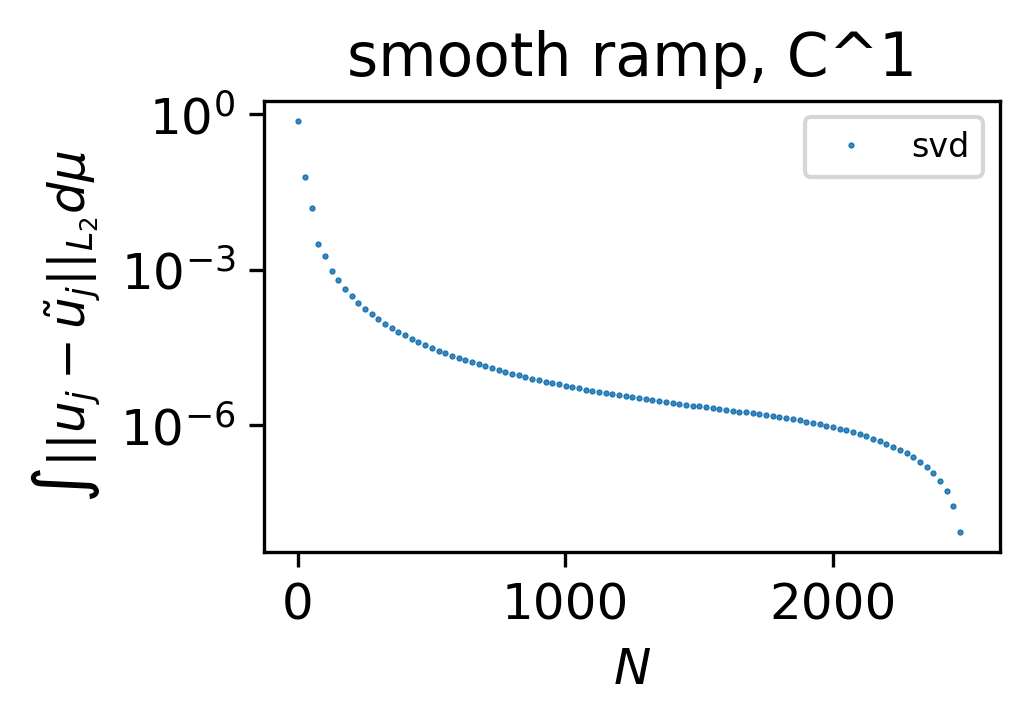

smooth ramp, C^2
mu_test =  0.5000500050005001
epsilon =  0.04001922754234522
cov =  [[1.92915843e-09]]
sorted.
SVD'ed.


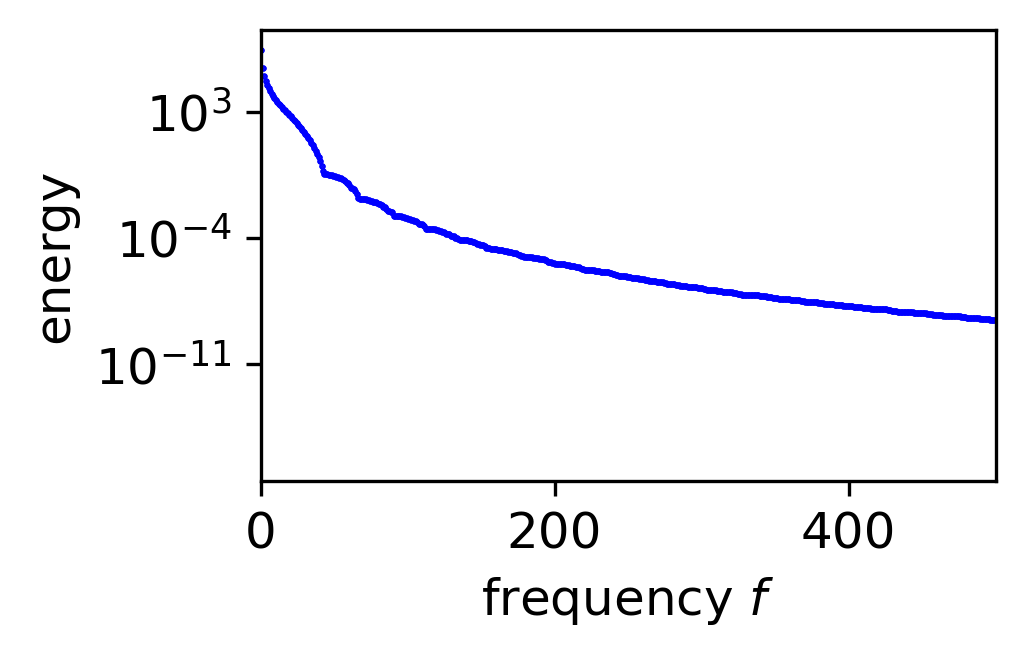

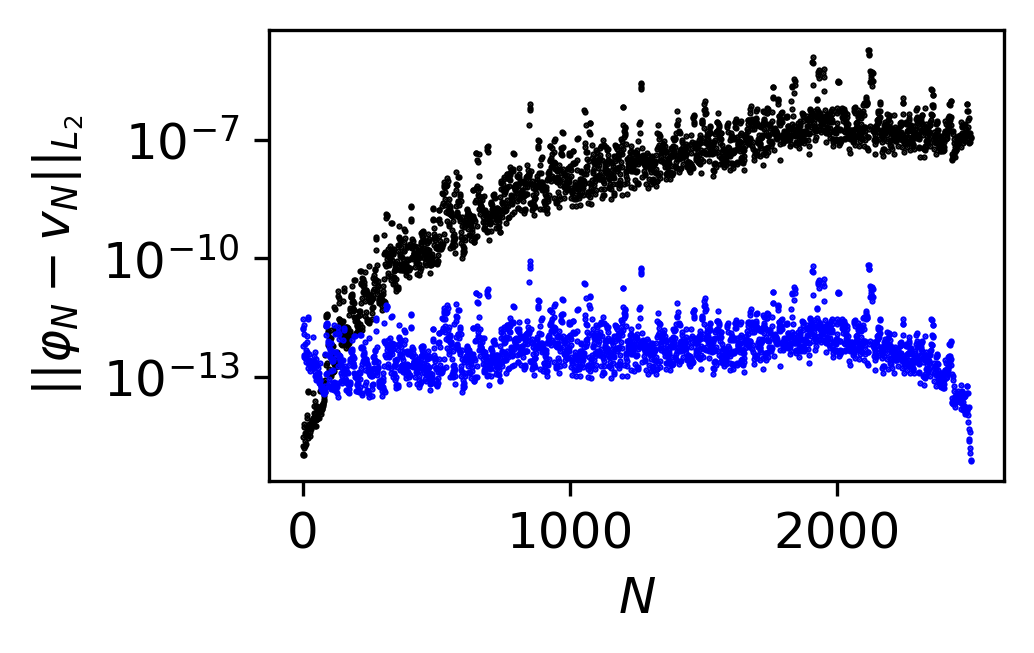

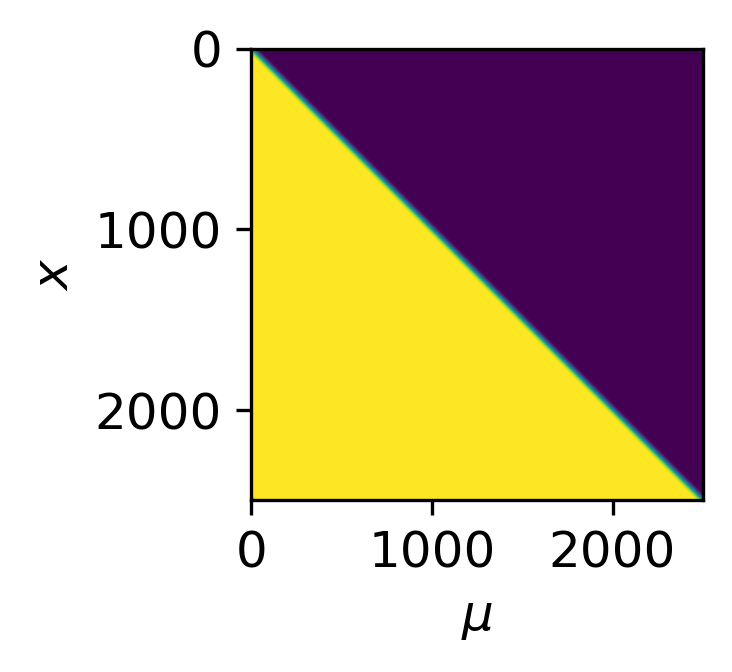

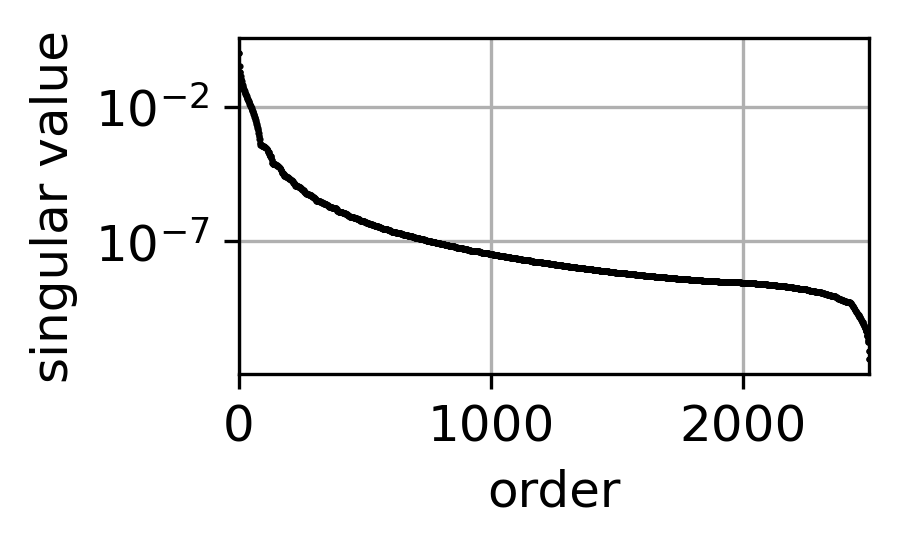

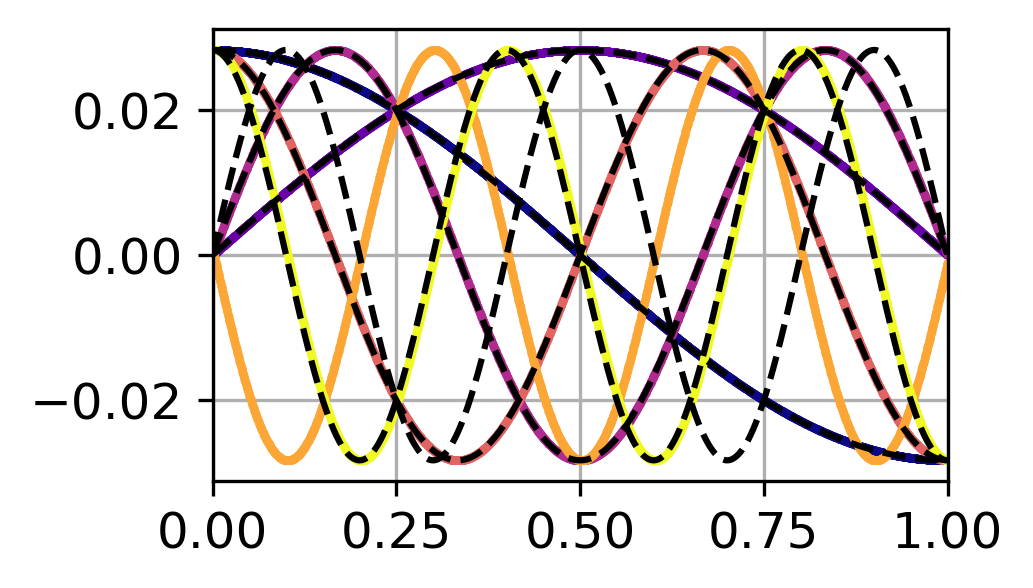

0 6 0.0
1 6 0.16666666666666666
2 6 0.3333333333333333
3 6 0.5
4 6 0.6666666666666666
5 6 0.8333333333333334


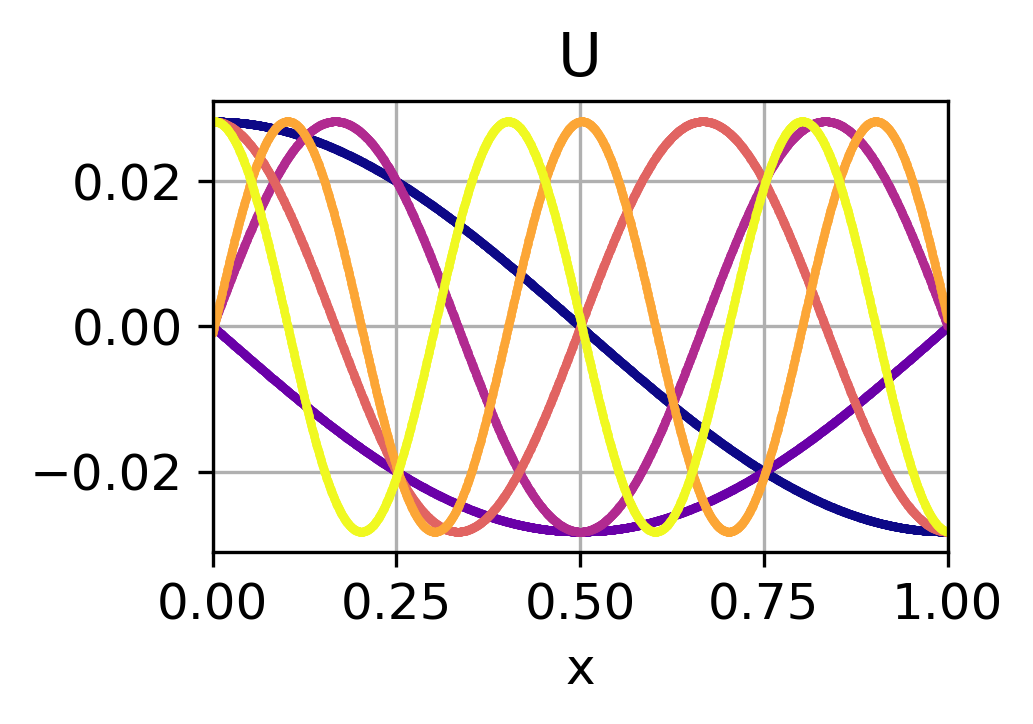

0 6 0.0
1 6 0.16666666666666666
2 6 0.3333333333333333
3 6 0.5
4 6 0.6666666666666666
5 6 0.8333333333333334


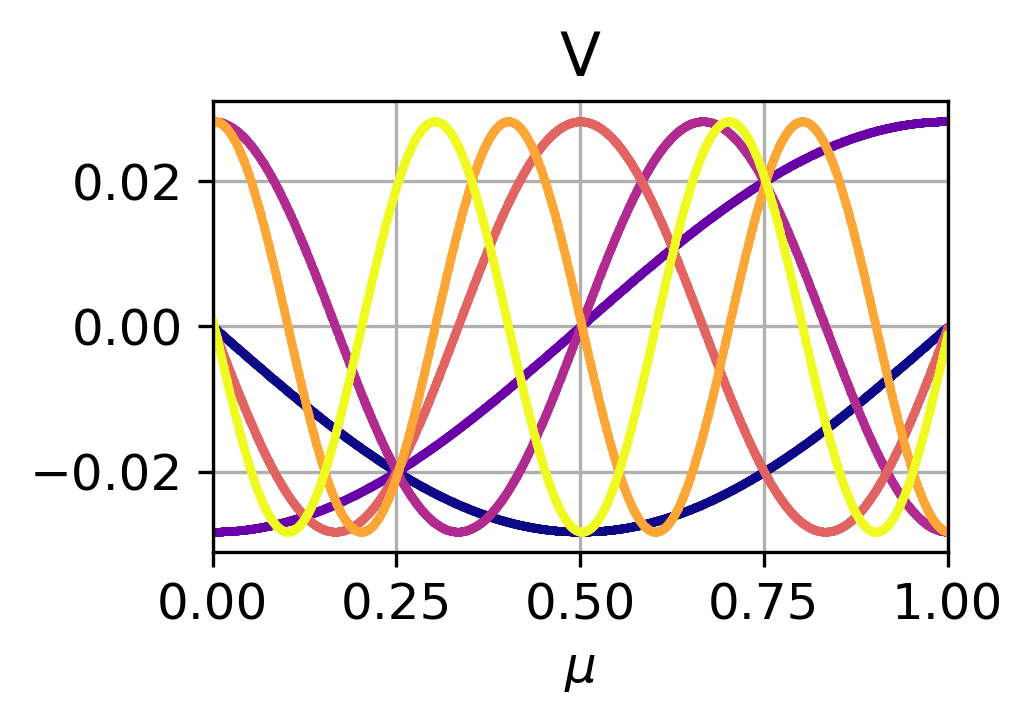

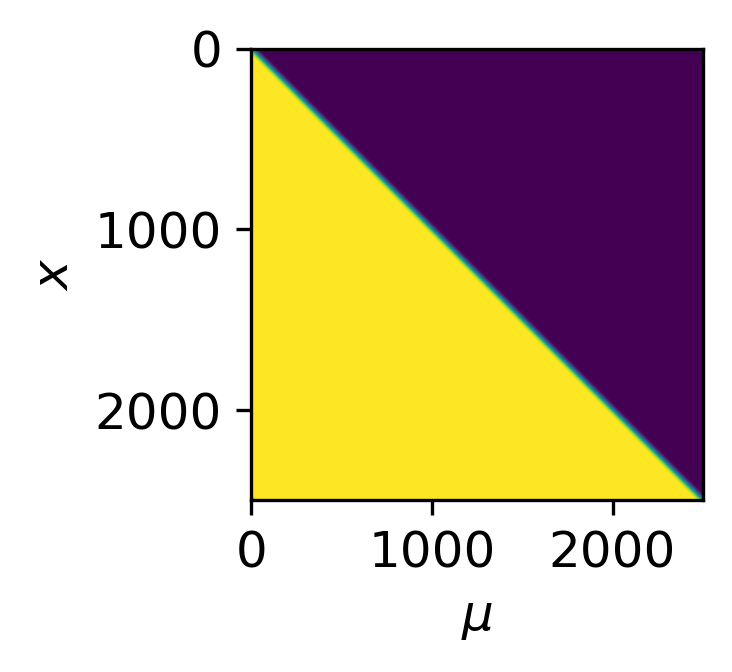

svd
calc_error: 2500 2500 2500
1, 26, 51, 76, 101, 126, 151, 176, 201, 226, 251, 276, 301, 326, 351, 376, 401, 426, 451, 476, 501, 526, 551, 576, 601, 626, 651, 676, 701, 726, 751, 776, 801, 826, 851, 876, 901, 926, 951, 976, 1001, 1026, 1051, 1076, 1101, 1126, 1151, 1176, 1201, 1226, 1251, 1276, 1301, 1326, 1351, 1376, 1401, 1426, 1451, 1476, 1501, 1526, 1551, 1576, 1601, 1626, 1651, 1676, 1701, 1726, 1751, 1776, 1801, 1826, 1851, 1876, 1901, 1926, 1951, 1976, 2001, 2026, 2051, 2076, 2101, 2126, 2151, 2176, 2201, 2226, 2251, 2276, 2301, 2326, 2351, 2376, 2401, 2426, 2451, 2476, 


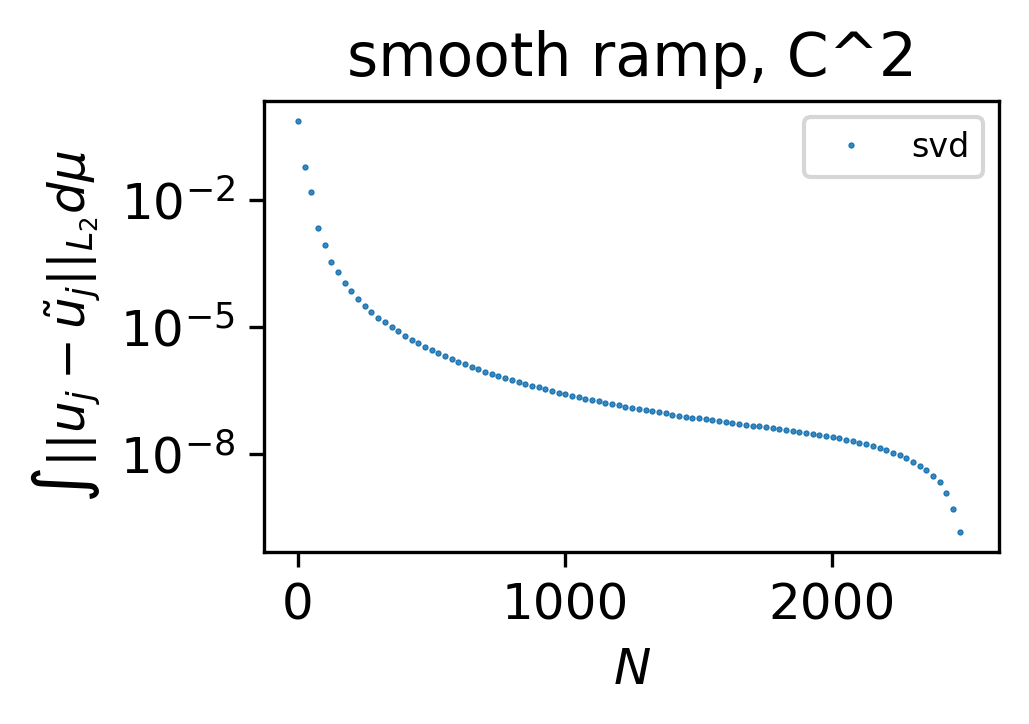

smooth ramp, C^3
mu_test =  0.5000500050005001
epsilon =  0.04591862571115181
cov =  [[3.22181004e-09]]
sorted.
SVD'ed.


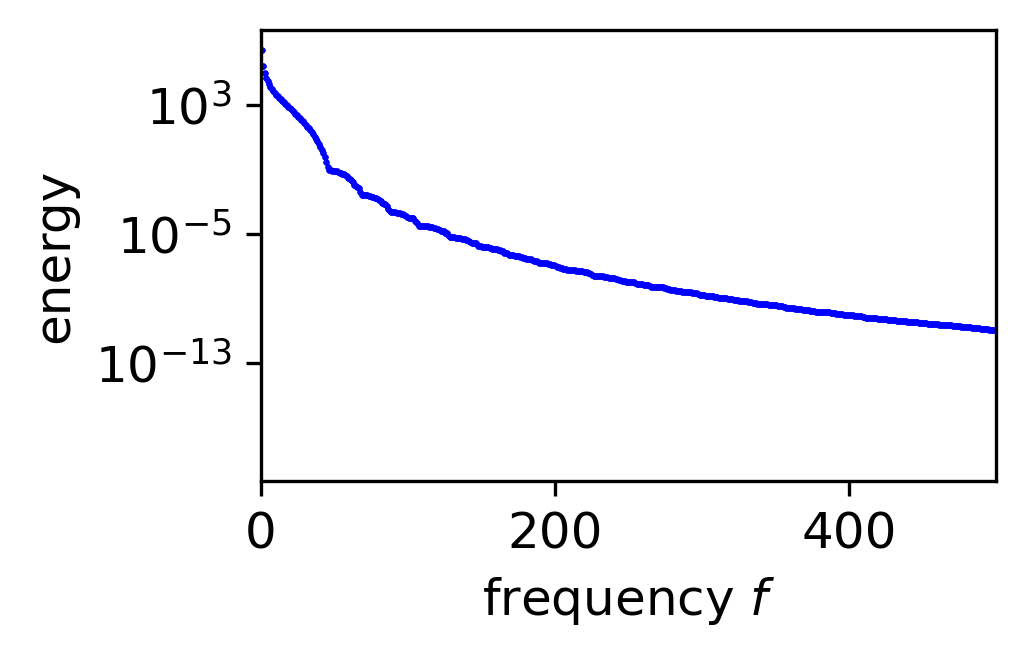

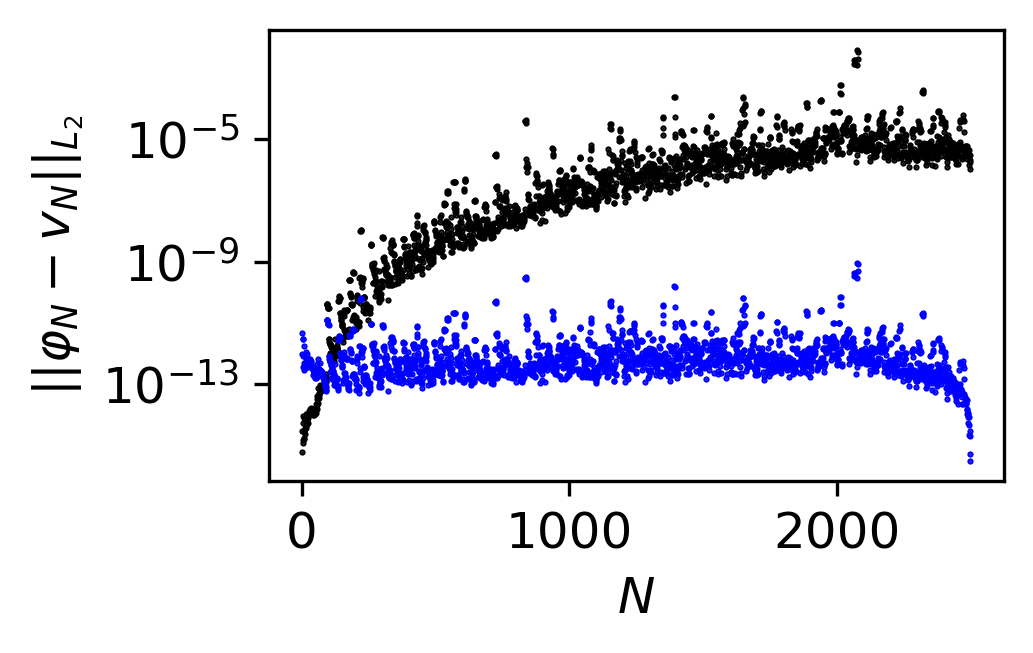

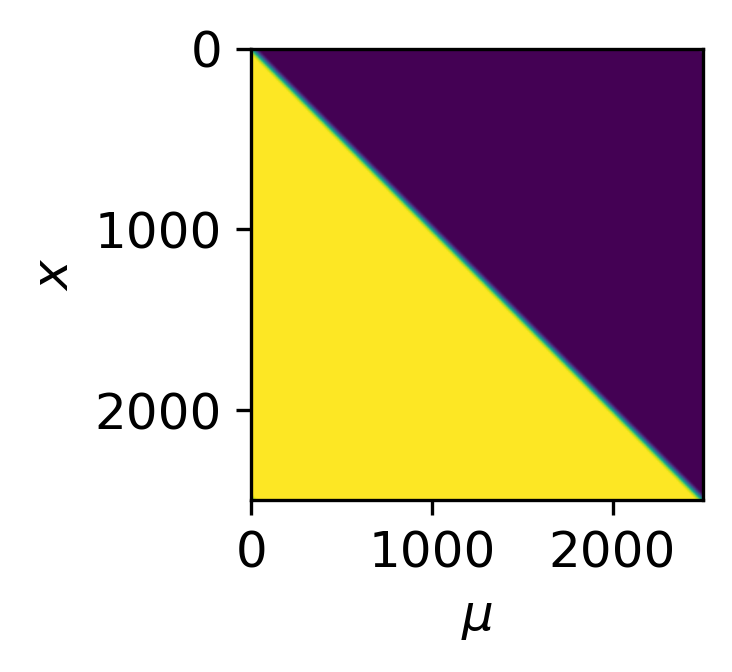

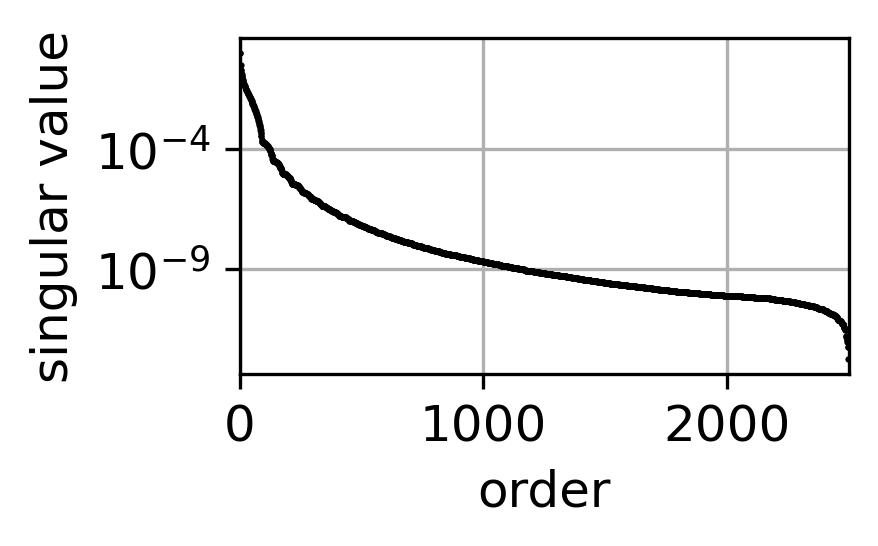

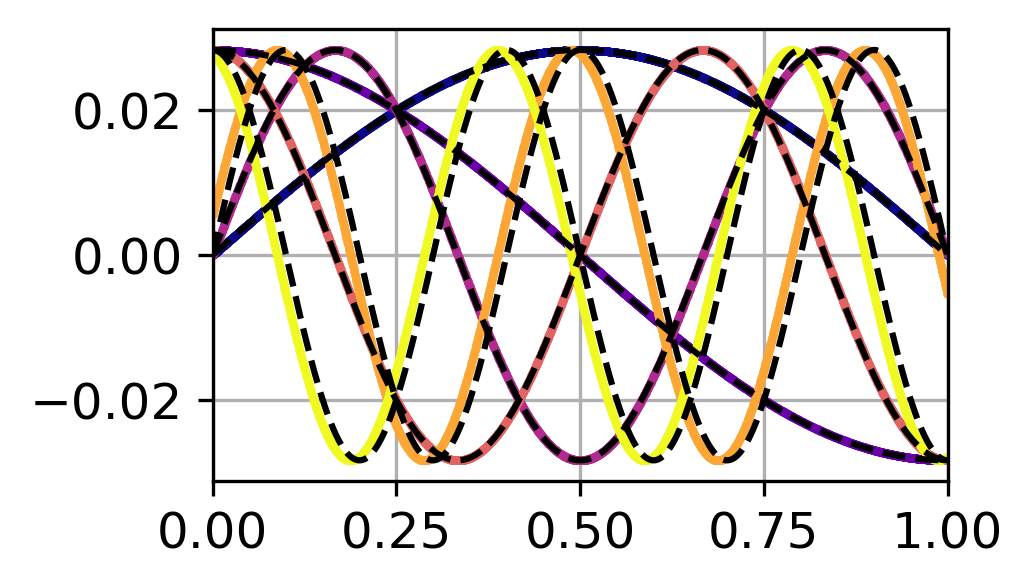

0 6 0.0
1 6 0.16666666666666666
2 6 0.3333333333333333
3 6 0.5
4 6 0.6666666666666666
5 6 0.8333333333333334


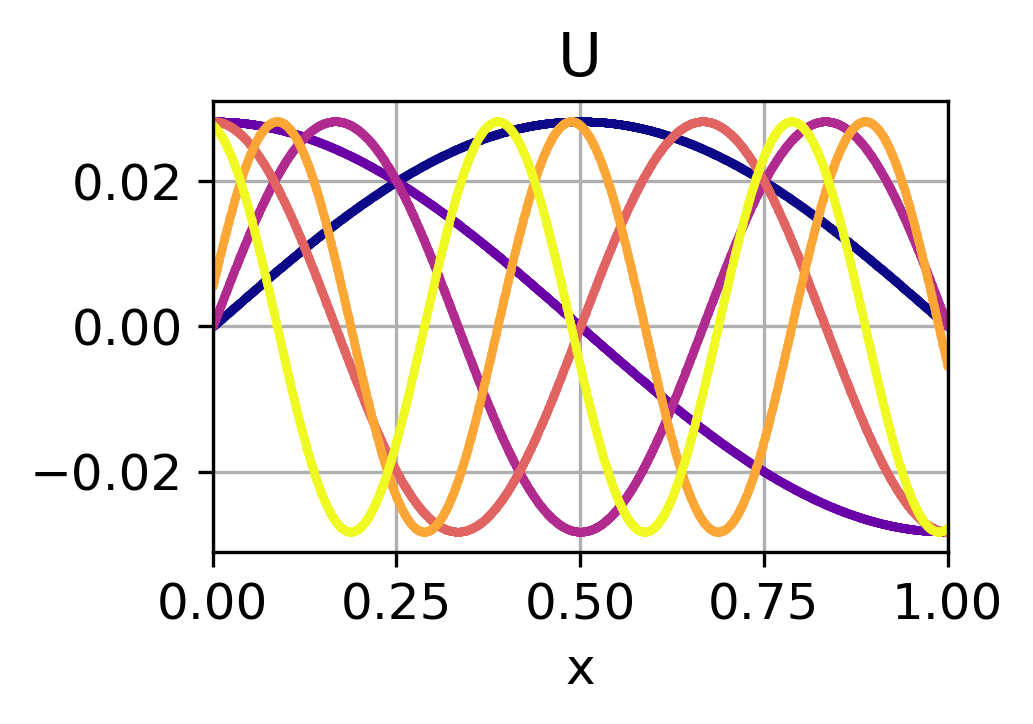

0 6 0.0
1 6 0.16666666666666666
2 6 0.3333333333333333
3 6 0.5
4 6 0.6666666666666666
5 6 0.8333333333333334


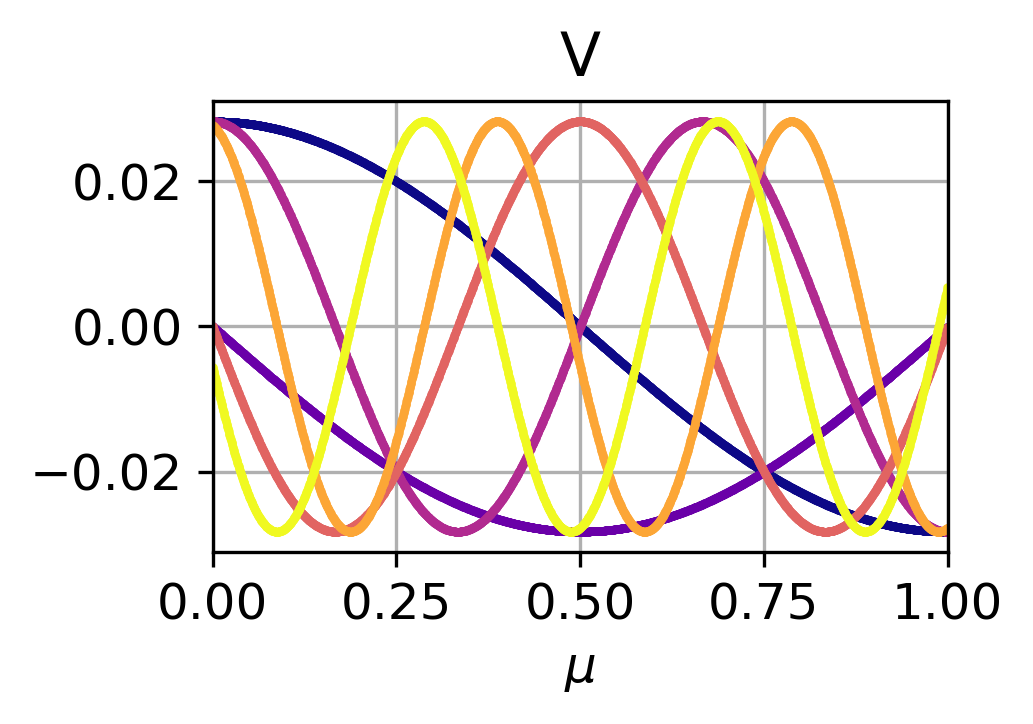

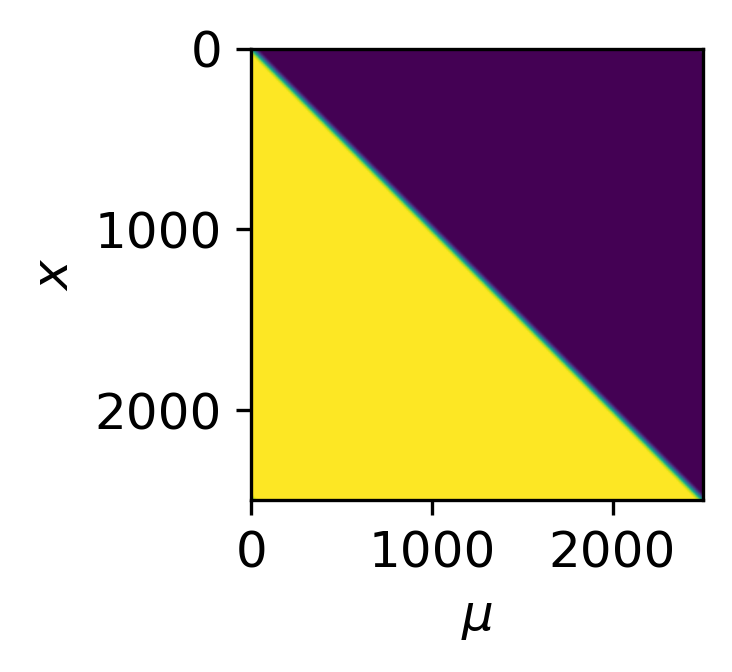

svd
calc_error: 2500 2500 2500
1, 26, 51, 76, 101, 126, 151, 176, 201, 226, 251, 276, 301, 326, 351, 376, 401, 426, 451, 476, 501, 526, 551, 576, 601, 626, 651, 676, 701, 726, 751, 776, 801, 826, 851, 876, 901, 926, 951, 976, 1001, 1026, 1051, 1076, 1101, 1126, 1151, 1176, 1201, 1226, 1251, 1276, 1301, 1326, 1351, 1376, 1401, 1426, 1451, 1476, 1501, 1526, 1551, 1576, 1601, 1626, 1651, 1676, 1701, 1726, 1751, 1776, 1801, 1826, 1851, 1876, 1901, 1926, 1951, 1976, 2001, 2026, 2051, 2076, 2101, 2126, 2151, 2176, 2201, 2226, 2251, 2276, 2301, 2326, 2351, 2376, 2401, 2426, 2451, 2476, 


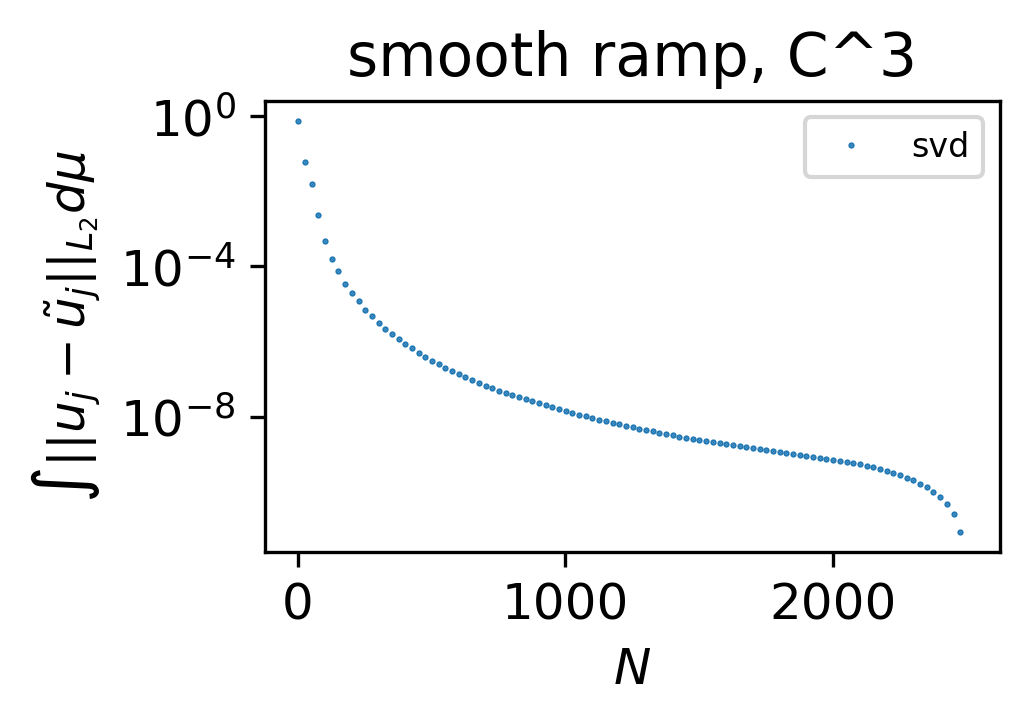

smooth ramp, C^4
mu_test =  0.5000500050005001
epsilon =  0.05116043398053234
cov =  [[4.55007091e-09]]
sorted.
SVD'ed.


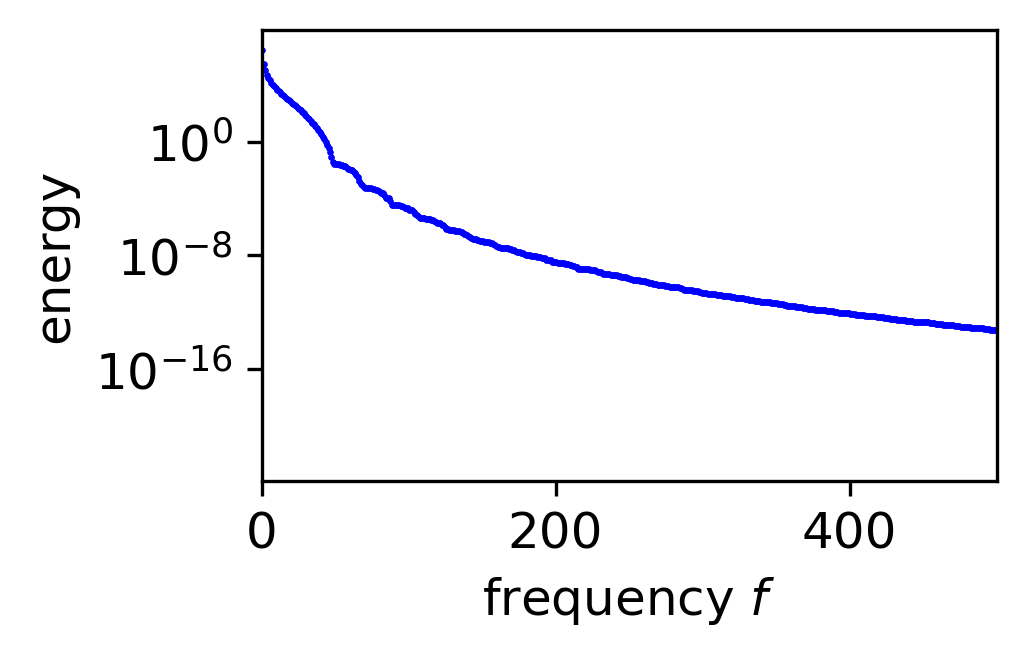

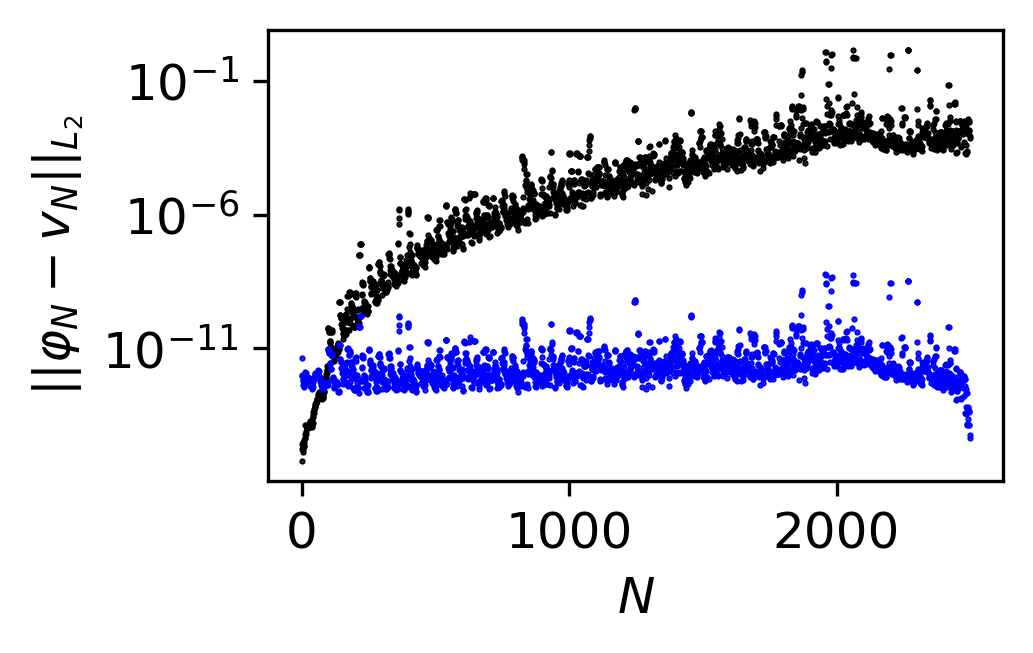

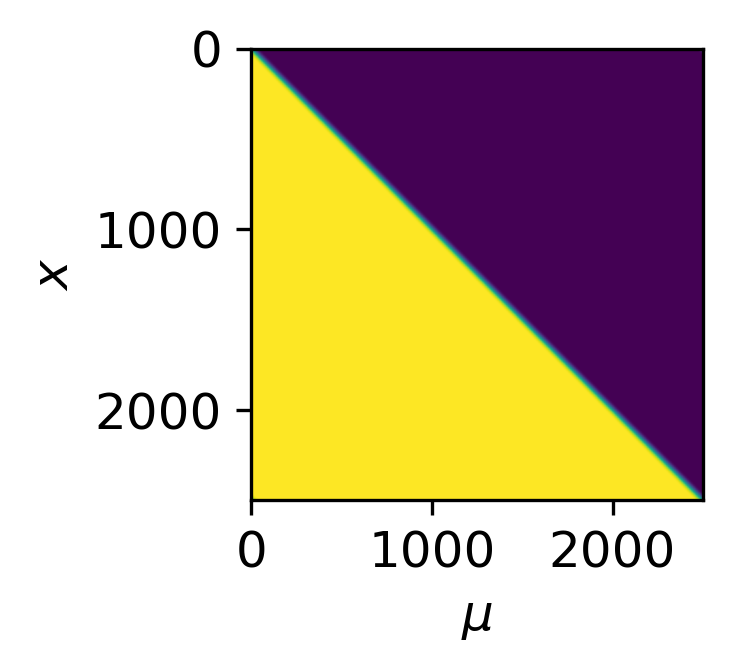

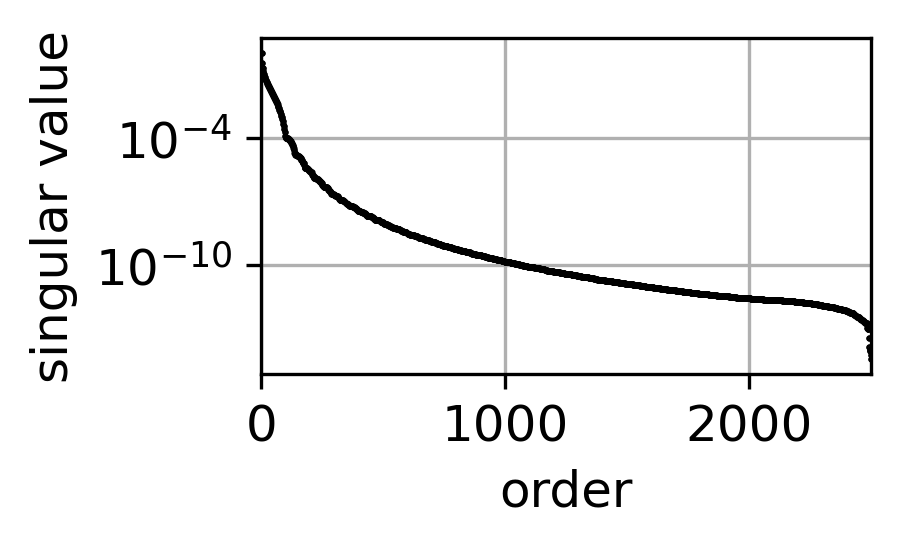

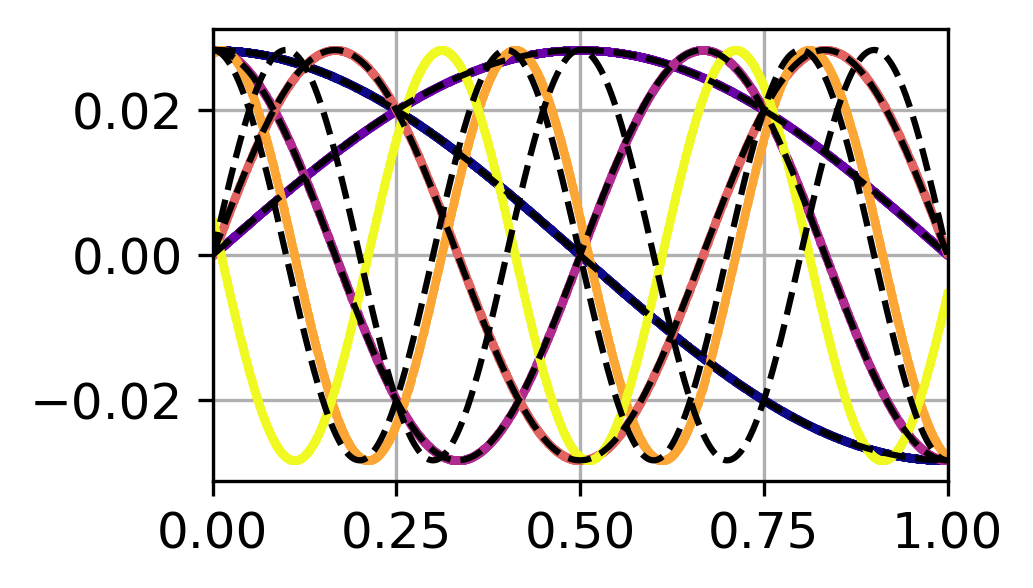

0 6 0.0
1 6 0.16666666666666666
2 6 0.3333333333333333
3 6 0.5
4 6 0.6666666666666666
5 6 0.8333333333333334


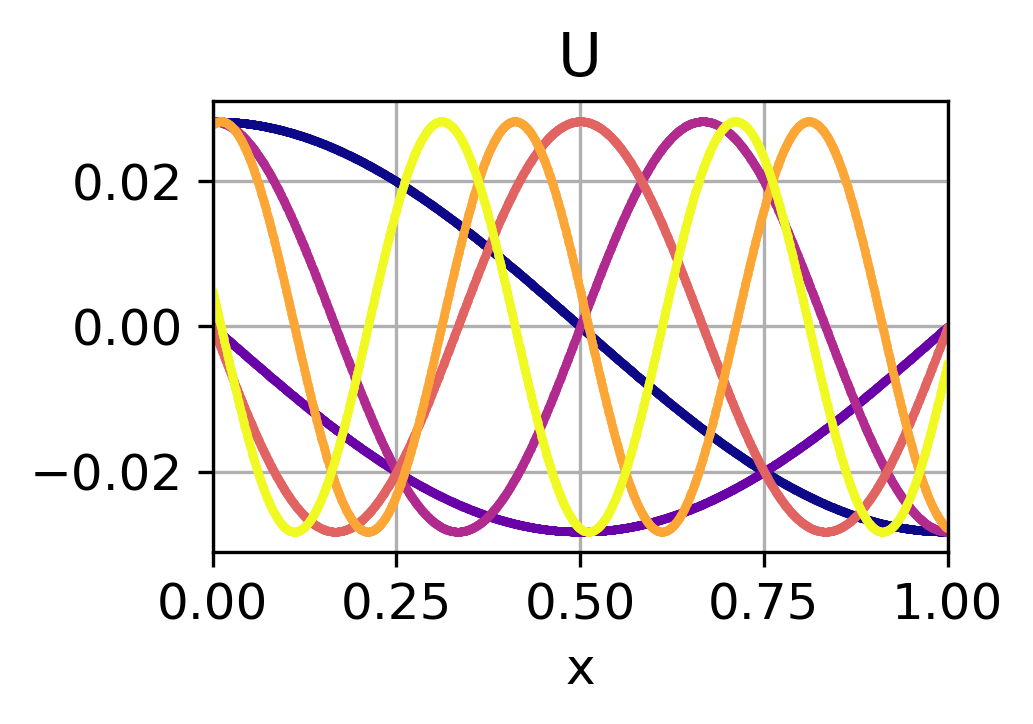

0 6 0.0
1 6 0.16666666666666666
2 6 0.3333333333333333
3 6 0.5
4 6 0.6666666666666666
5 6 0.8333333333333334


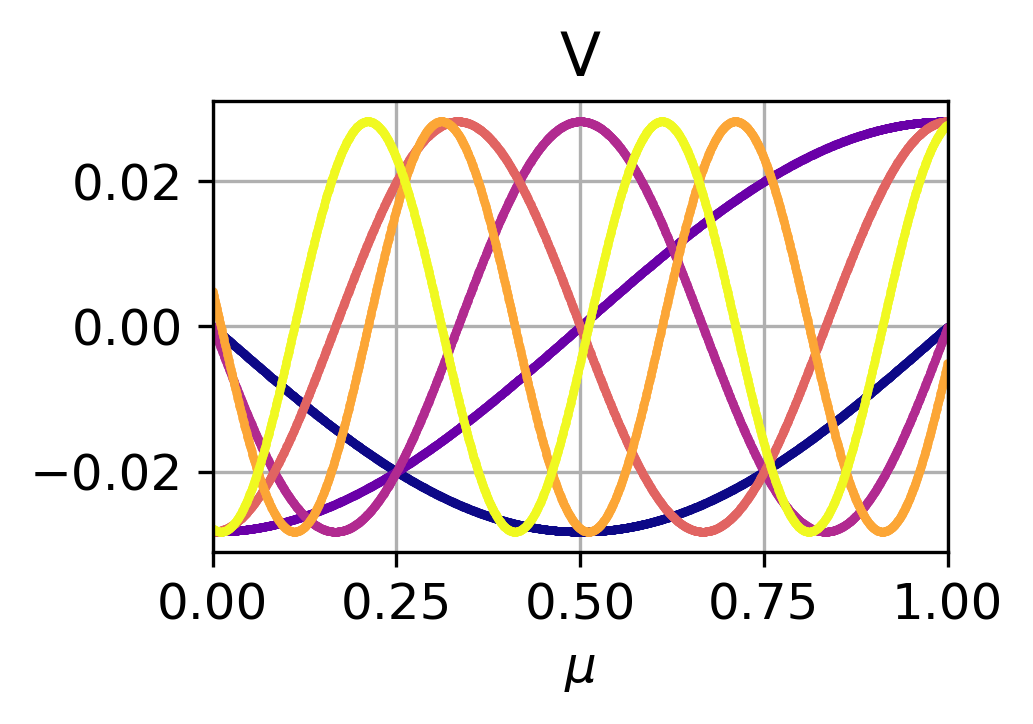

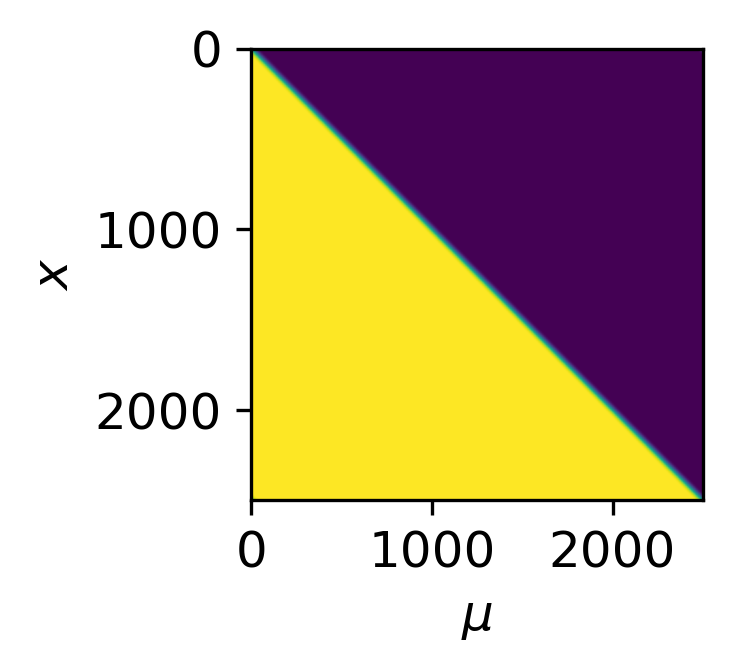

svd
calc_error: 2500 2500 2500
1, 26, 51, 76, 101, 126, 151, 176, 201, 226, 251, 276, 301, 326, 351, 376, 401, 426, 451, 476, 501, 526, 551, 576, 601, 626, 651, 676, 701, 726, 751, 776, 801, 826, 851, 876, 901, 926, 951, 976, 1001, 1026, 1051, 1076, 1101, 1126, 1151, 1176, 1201, 1226, 1251, 1276, 1301, 1326, 1351, 1376, 1401, 1426, 1451, 1476, 1501, 1526, 1551, 1576, 1601, 1626, 1651, 1676, 1701, 1726, 1751, 1776, 1801, 1826, 1851, 1876, 1901, 1926, 1951, 1976, 2001, 2026, 2051, 2076, 2101, 2126, 2151, 2176, 2201, 2226, 2251, 2276, 2301, 2326, 2351, 2376, 2401, 2426, 2451, 2476, 


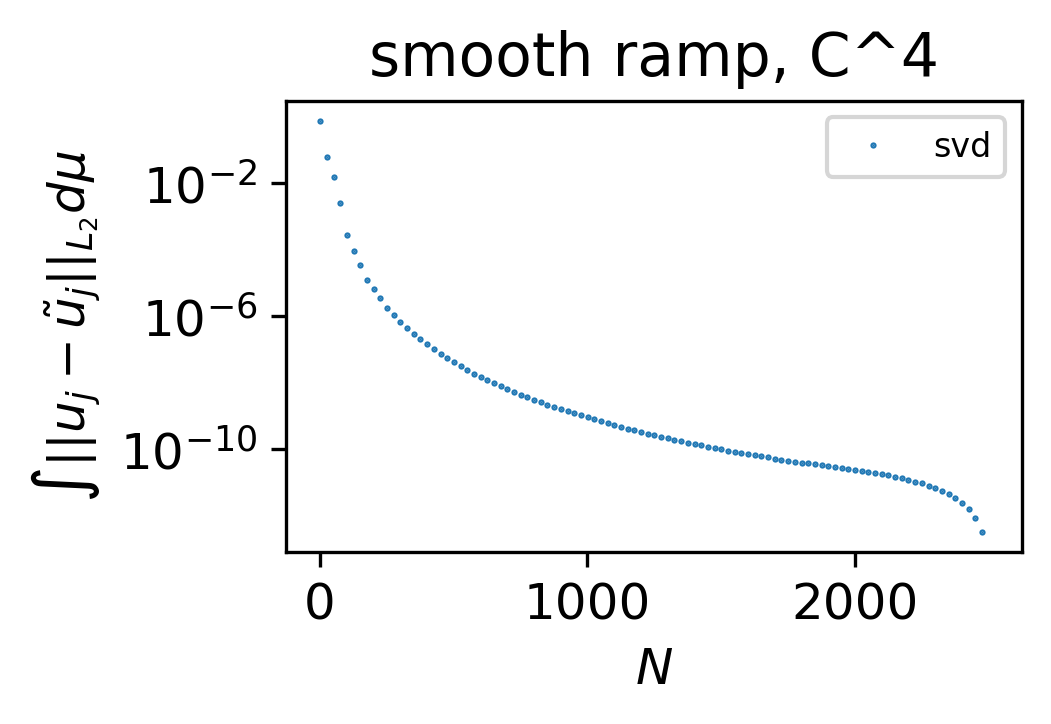

smooth ramp, C^5
mu_test =  0.5000500050005001
epsilon =  0.0559208586827702
cov =  [[5.89521541e-09]]
sorted.
SVD'ed.


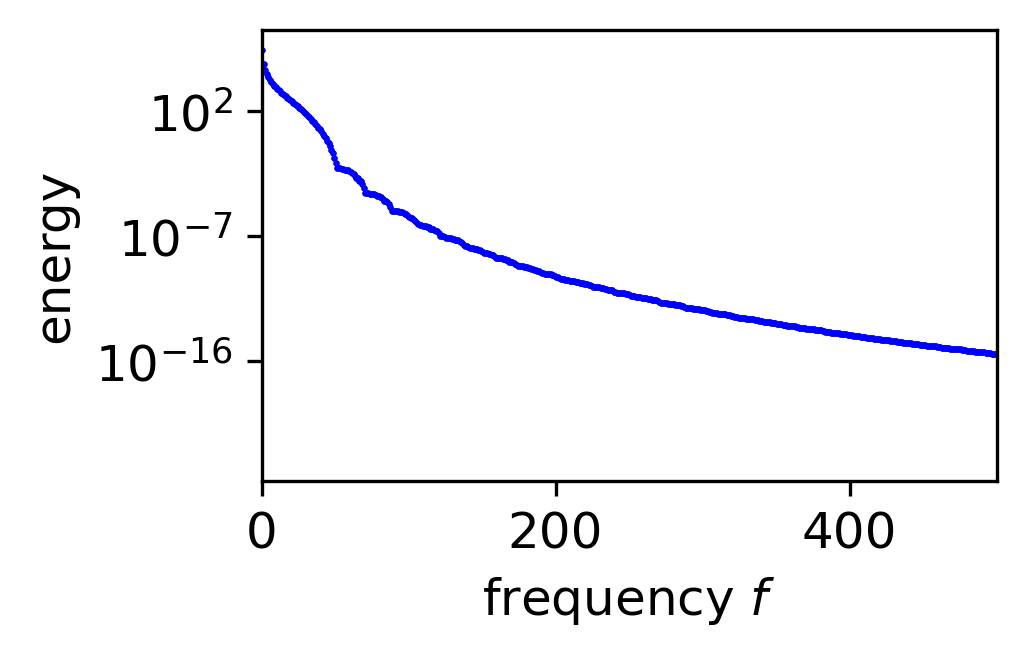

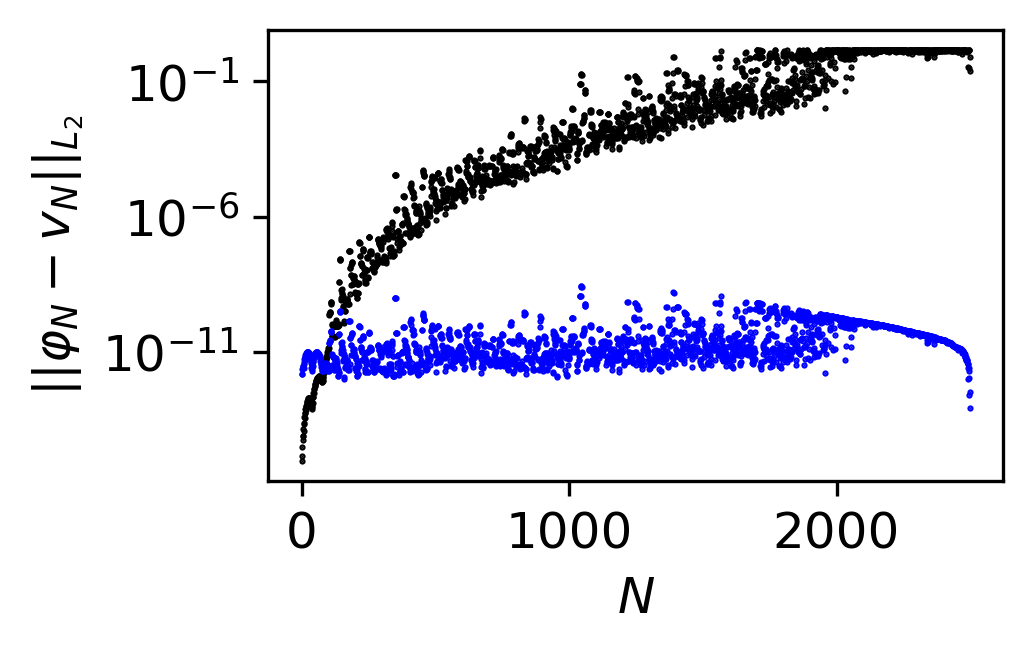

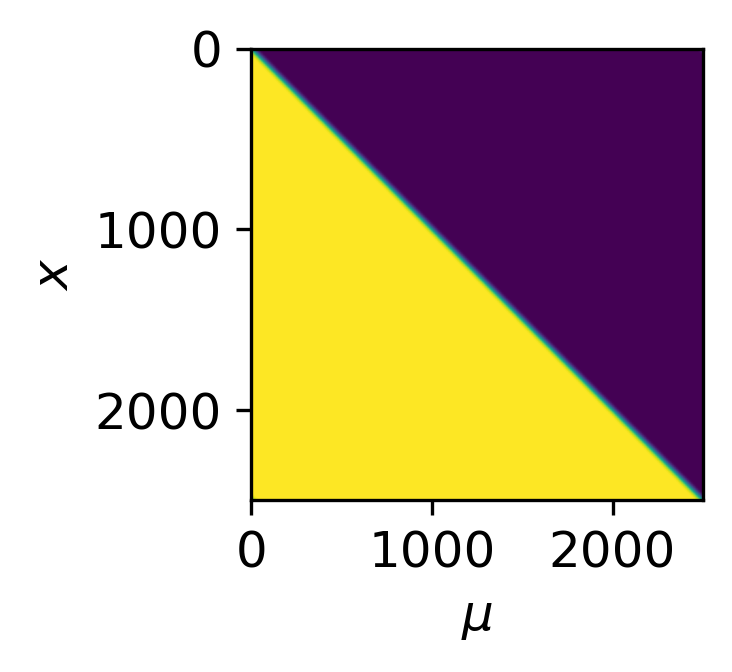

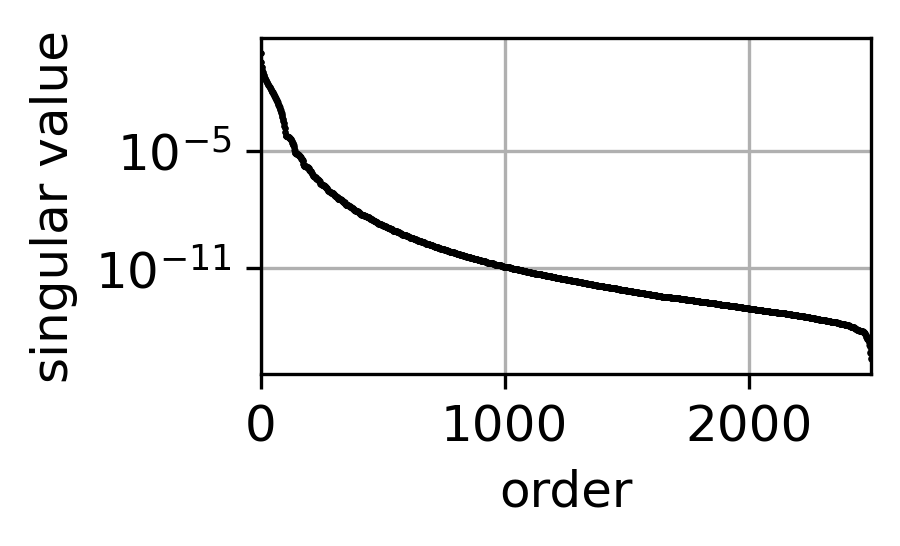

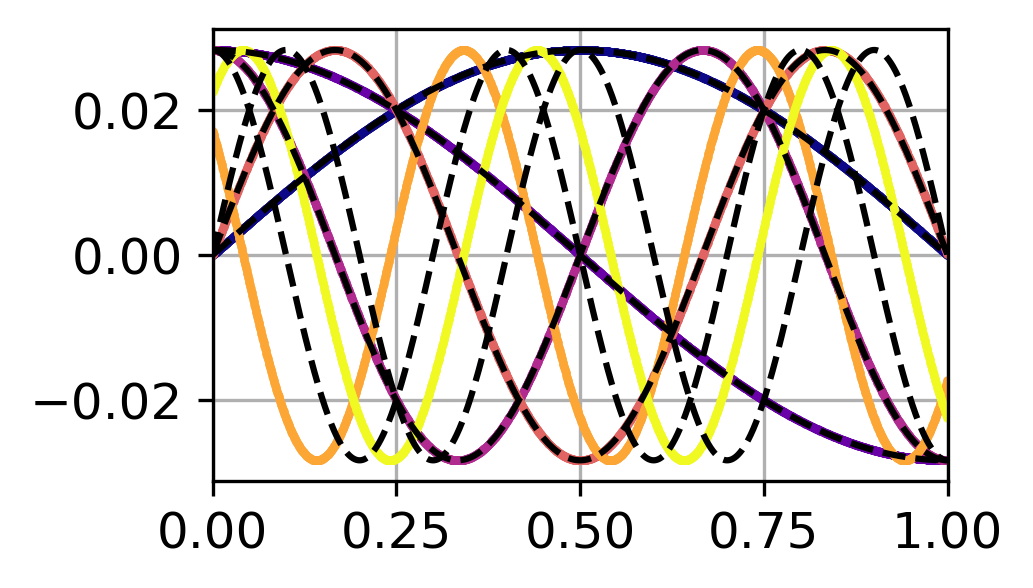

0 6 0.0
1 6 0.16666666666666666
2 6 0.3333333333333333
3 6 0.5
4 6 0.6666666666666666
5 6 0.8333333333333334


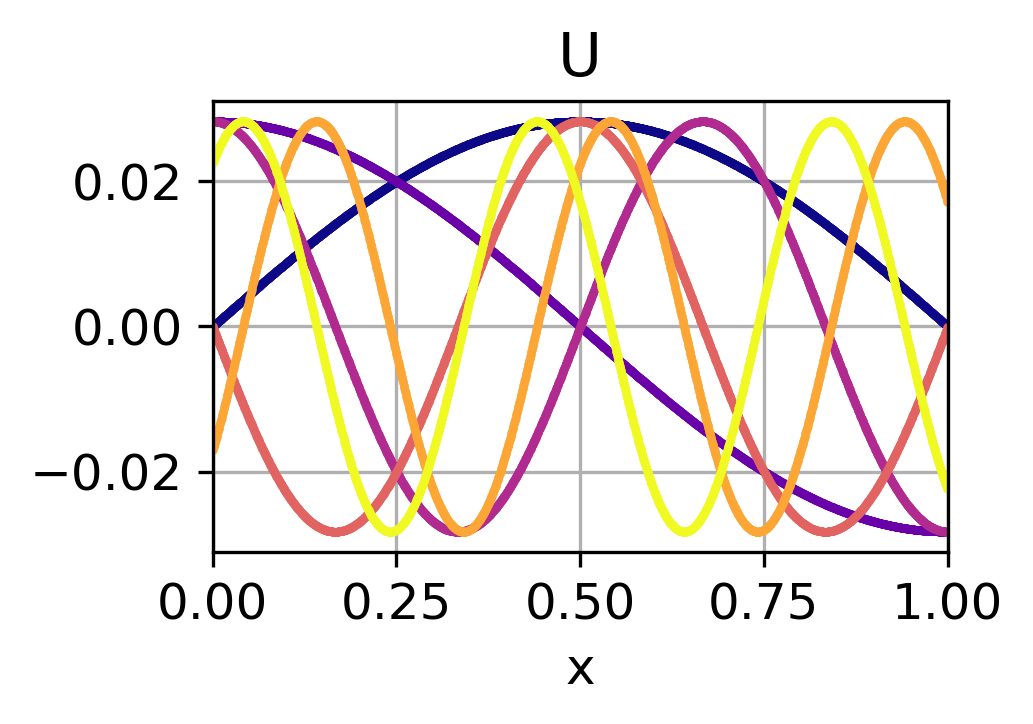

0 6 0.0
1 6 0.16666666666666666
2 6 0.3333333333333333
3 6 0.5
4 6 0.6666666666666666
5 6 0.8333333333333334


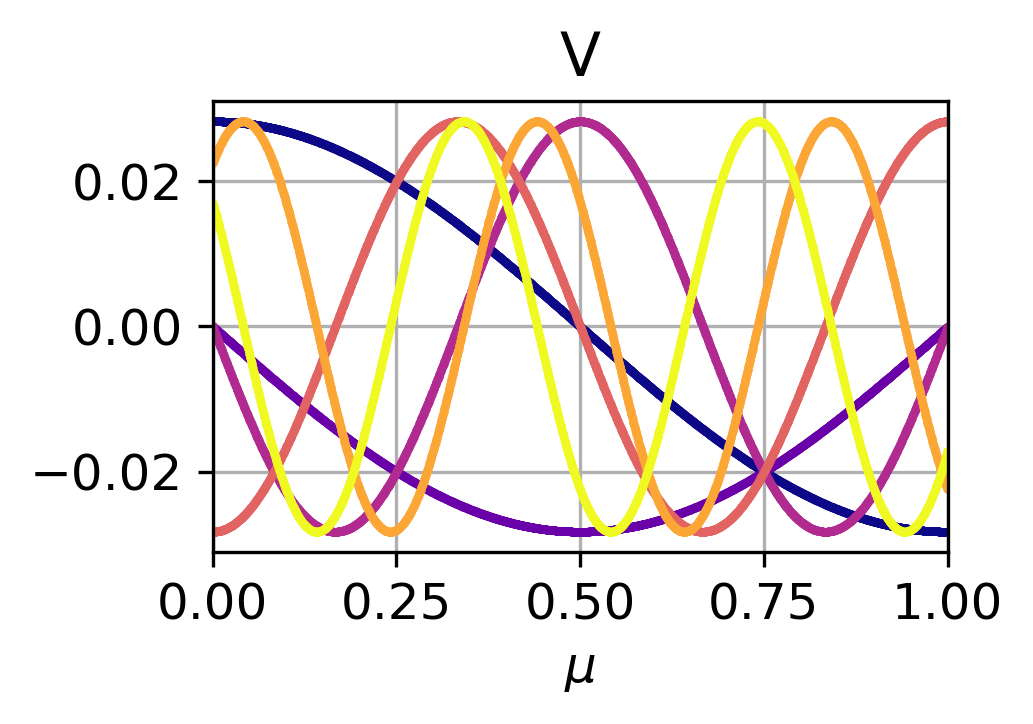

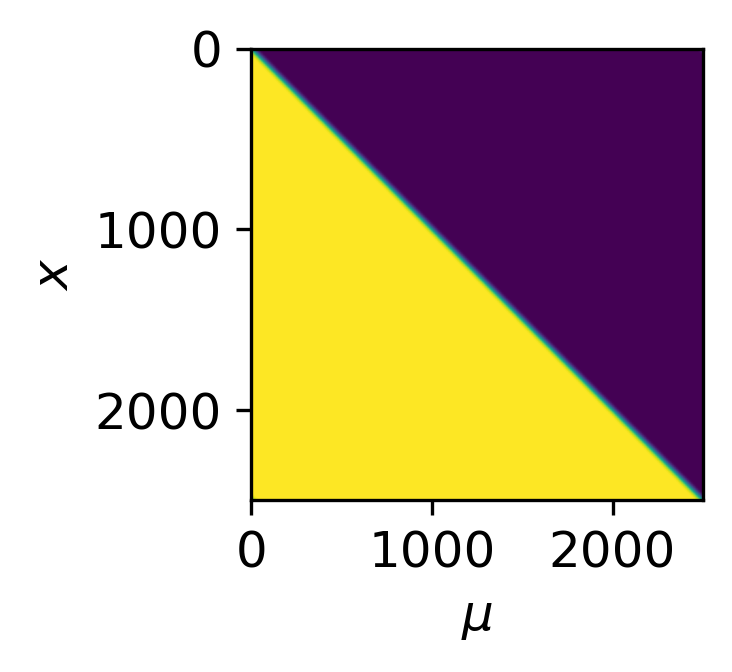

svd
calc_error: 2500 2500 2500
1, 26, 51, 76, 101, 126, 151, 176, 201, 226, 251, 276, 301, 326, 351, 376, 401, 426, 451, 476, 501, 526, 551, 576, 601, 626, 651, 676, 701, 726, 751, 776, 801, 826, 851, 876, 901, 926, 951, 976, 1001, 1026, 1051, 1076, 1101, 1126, 1151, 1176, 1201, 1226, 1251, 1276, 1301, 1326, 1351, 1376, 1401, 1426, 1451, 1476, 1501, 1526, 1551, 1576, 1601, 1626, 1651, 1676, 1701, 1726, 1751, 1776, 1801, 1826, 1851, 1876, 1901, 1926, 1951, 1976, 2001, 2026, 2051, 2076, 2101, 2126, 2151, 2176, 2201, 2226, 2251, 2276, 2301, 2326, 2351, 2376, 2401, 2426, 2451, 2476, 


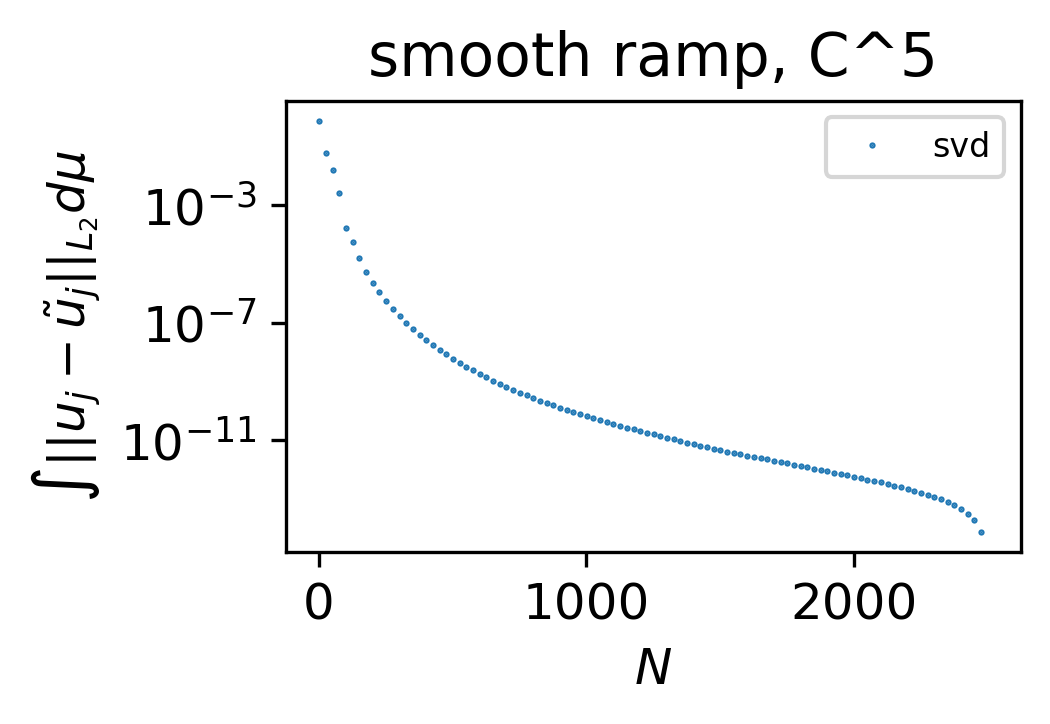

sigmoid (sin)
mu_test =  0.5000500050005001
epsilon =  0.019789519904034873
cov =  [[1.19085129e-09]]
sorted.
SVD'ed.


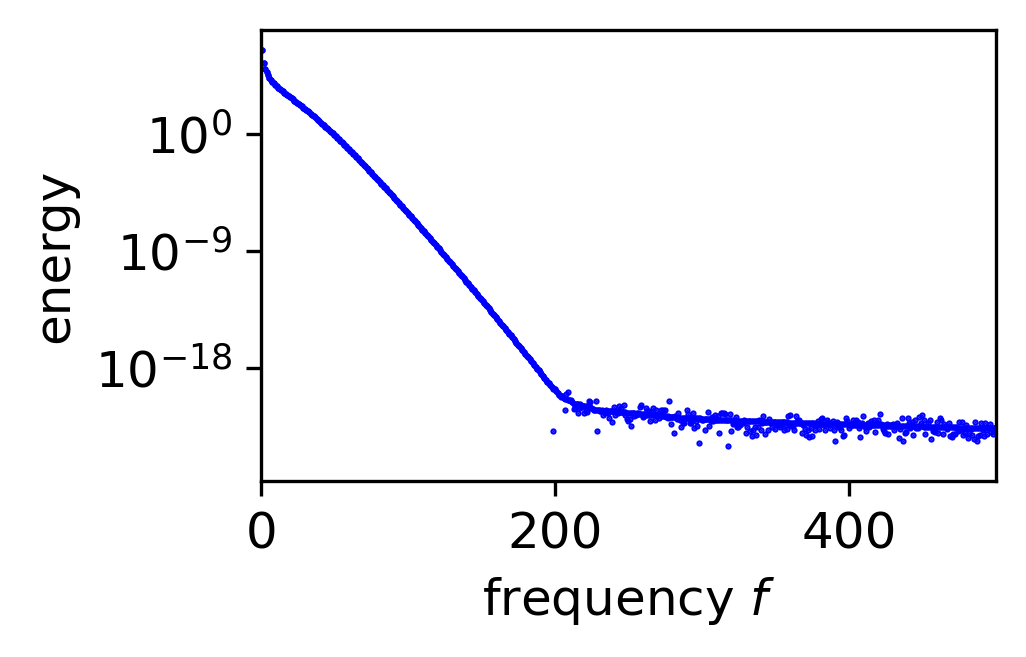

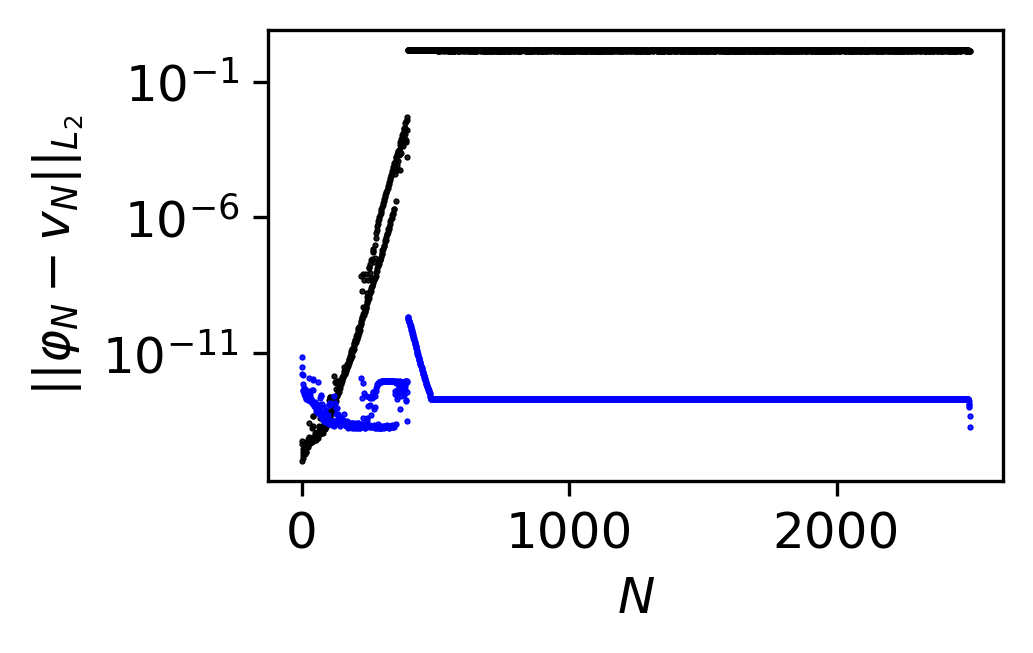

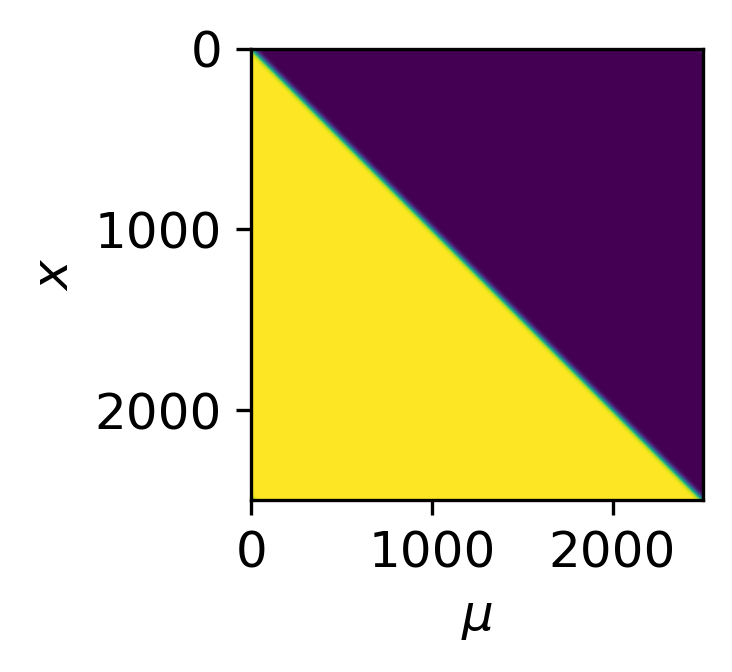

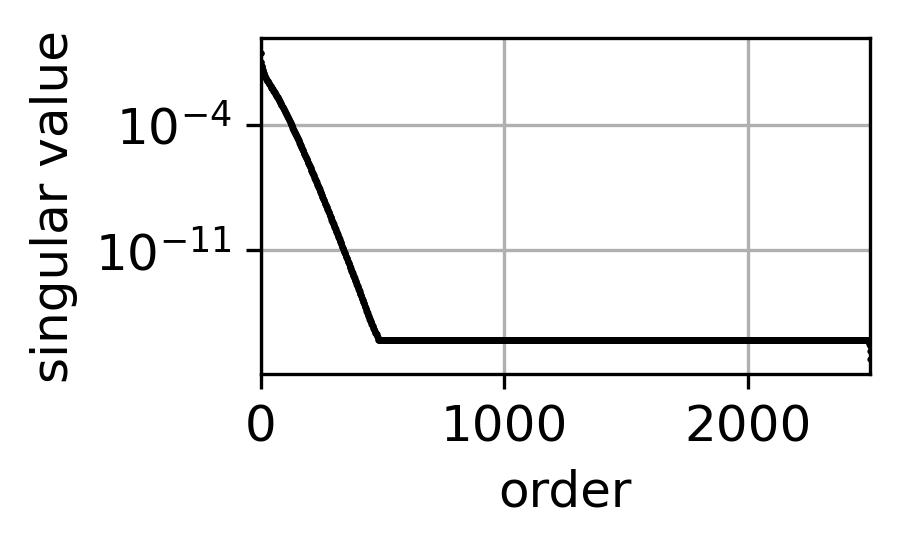

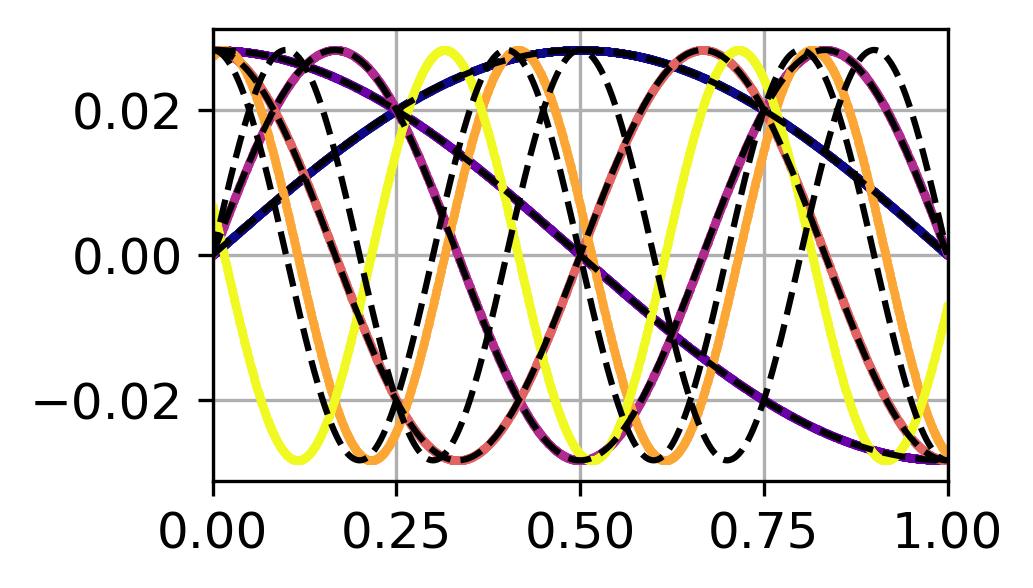

0 6 0.0
1 6 0.16666666666666666
2 6 0.3333333333333333
3 6 0.5
4 6 0.6666666666666666
5 6 0.8333333333333334


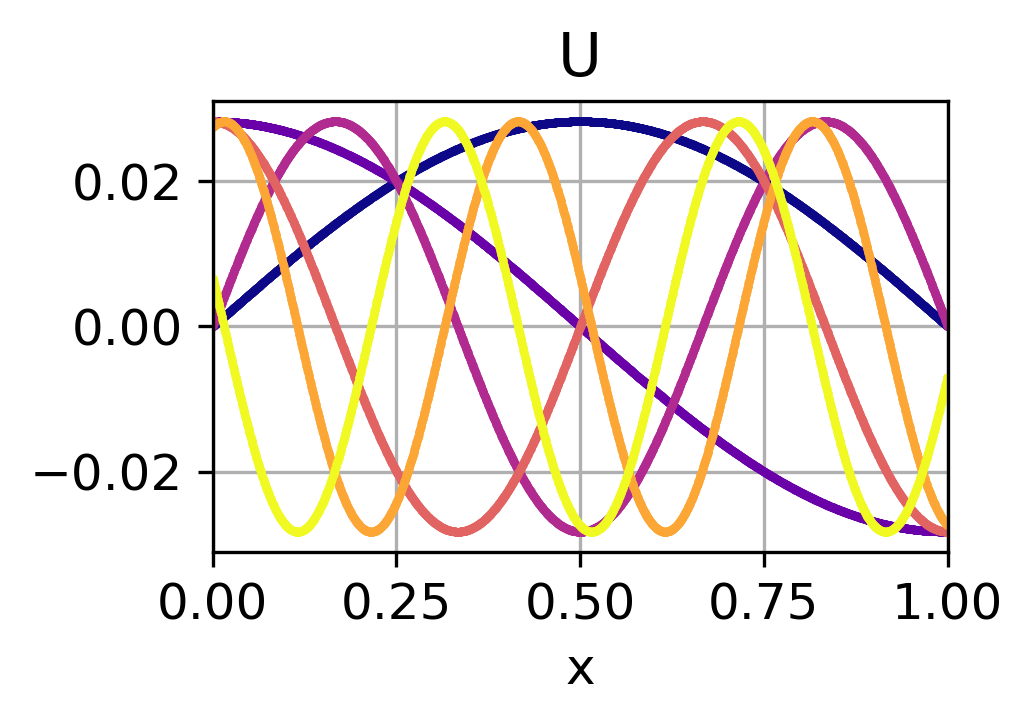

0 6 0.0
1 6 0.16666666666666666
2 6 0.3333333333333333
3 6 0.5
4 6 0.6666666666666666
5 6 0.8333333333333334


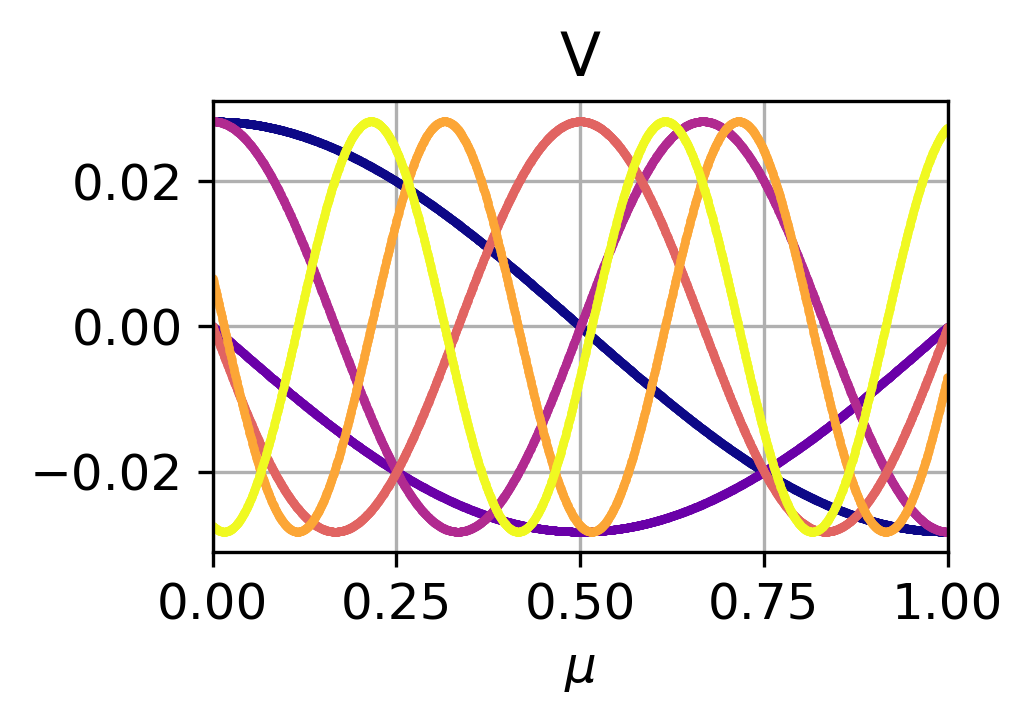

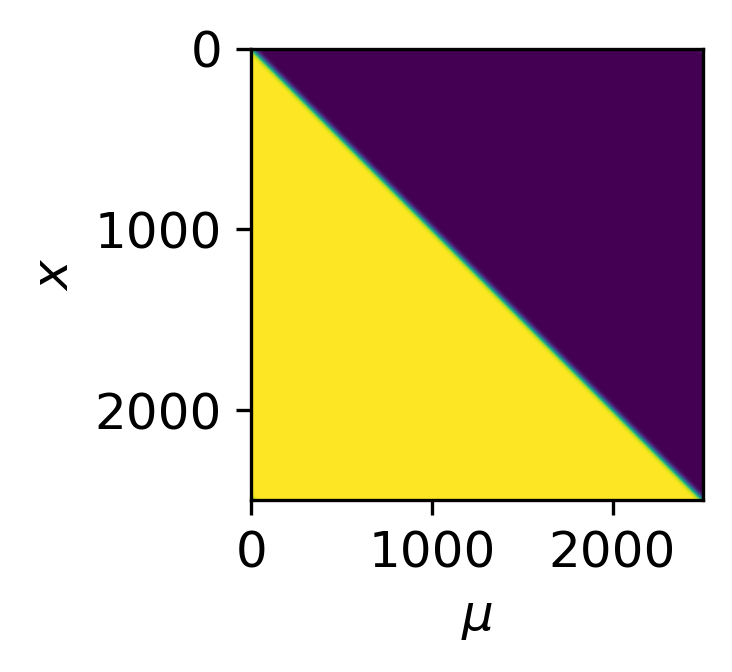

svd
calc_error: 2500 2500 2500
1, 26, 51, 76, 101, 126, 151, 176, 201, 226, 251, 276, 301, 326, 351, 376, 401, 426, 451, 476, 501, 526, 551, 576, 601, 626, 651, 676, 701, 726, 751, 776, 801, 826, 851, 876, 901, 926, 951, 976, 1001, 1026, 1051, 1076, 1101, 1126, 1151, 1176, 1201, 1226, 1251, 1276, 1301, 1326, 1351, 1376, 1401, 1426, 1451, 1476, 1501, 1526, 1551, 1576, 1601, 1626, 1651, 1676, 1701, 1726, 1751, 1776, 1801, 1826, 1851, 1876, 1901, 1926, 1951, 1976, 2001, 2026, 2051, 2076, 2101, 2126, 2151, 2176, 2201, 2226, 2251, 2276, 2301, 2326, 2351, 2376, 2401, 2426, 2451, 2476, 


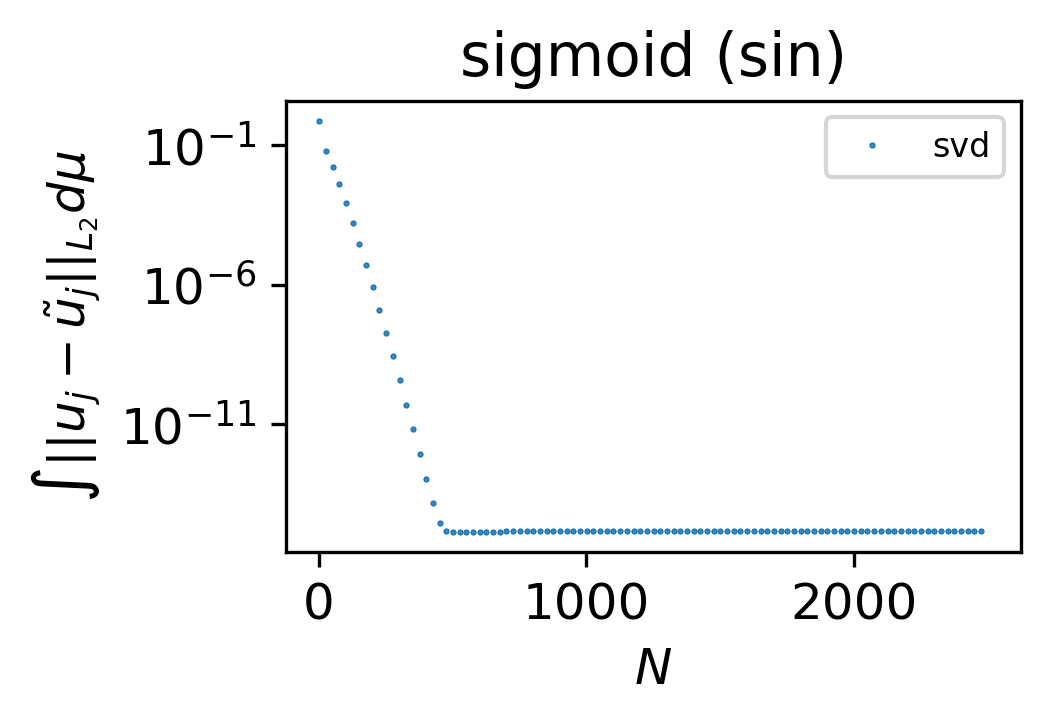

In [9]:
trig_basis_odd = TrigonometricOdd(x())
f_s = f_c = (2*np.arange(m//2)+1)/2  # i = np.arange(m//2)
frequencies = np.c_[f_s[:, None], f_c[:, None]].ravel()


results_path = "C:/Users/florianma/Dropbox/Kol-N-width-Oslo-Ulm/n_widths_for_transport/results/hvo_"

for j, u_k in enumerate(initc):  # 9
    print(u_k.name)
    u_k.fit_to(u_C0, tt)
    X = u_k.half_wave_odd(x(), mu())

    sort_trig_basis(trig_basis_odd, X)
    print("sorted.")
    #save_im(X, str(j))

    svd_basis = SVD(X)
    print("SVD'ed.")
    
    # plot energy vs frequency
    c = trig_basis_odd.U.T @ X
    c_n = (c**2).sum(axis=1)
    fig, ax = plt.subplots()
    ax.plot(frequencies, c_n, "b.", ms=1)
    ax.set_xlabel("frequency $f$")
    ax.set_ylabel("energy")
    ax.set_yscale('log')
    ax.set_xlim([0, 500])
    plt.show()
    
    e = SVD_vs_trig_basis(svd_basis, trig_basis_odd)
    fig, ax = plt.subplots()
    ax.plot(e, "k.", ms=1)
    ax.plot(e*svd_basis.S, "b.", ms=1)
    ax.set_yscale('log')
    ax.set_xlabel(r'$N$')
    ax.set_ylabel(r'$|| \varphi_N - v_N ||_{L_2}$')
    plt.show()

    plot_paramspace(X)
    plot_singular_values(svd_basis.S)
    plot_and_compare_modes(x(), svd_basis.U, trig_basis_odd.U)

    is_flipped = np.median(svd_basis.U/trig_basis_odd.U, axis=0) < 0
    svd_basis.U[:, is_flipped] *= -1
    svd_basis.VT[is_flipped, :] *= -1

    # TODO:
    #errrrr = ((svd_basis.U-trig_basis_odd.U)**2).sum(axis=0)**.5
    #fig, ax1 = plt.subplots()
    #ax1.plot(errrrr, "k.", ms=1)
    #ax1.set_yscale('log')
    #ax1.grid(which="both")
    #plt.tight_layout()
    #plt.show()
    
    plot_modes(x(), svd_basis.U, r=6)
    plt.xlabel("x")
    plt.title("U")
    plt.show()
    plot_modes(mu(), svd_basis.VT.T, r=6)
    plt.xlabel("$\mu$")
    plt.title("V")
    plt.show()

    #mu_test = Domain([mu.min, mu.max], n*2)()
    mu_test = np.random.rand(n,)
    X_test = u_k.half_wave_odd(x(), mu_test)
    X_test = X

    plot_paramspace(X_test)

    basis_all = [svd_basis]
    for i, basis in enumerate(basis_all):  # 6
        print(basis.name)
        
        delta_n, d_n = basis.calc_error(X_test, r)
        results[i, j, 0, :] = delta_n
        results[i, j, 1, :] = d_n
        #np.save(results_path+"_delta_n_"+basis.name+"_"+u_k.name+".npy", delta_n)
        #np.save(results_path+"_d_n_"+basis.name+"_"+u_k.name+".npy", d_n)
    
    fig, ax = plt.subplots()
    for i, bv in enumerate(basis_all):
        ax.plot(results[i][j][0], ".", ms=1, label=bv.name)
    ax.set_yscale('log')
    plt.title(u_k.name)
    plt.legend(prop={'size': 8})
    plt.xlabel(r'$N$')
    plt.ylabel(r'$\int || u_j - \tilde{u}_j ||_{L_2} d\mu$')
    plt.show()


linear ramp, C^0
$linear ramp, C^0$
$\int_E_n(u(\mu;x)) d\mu$


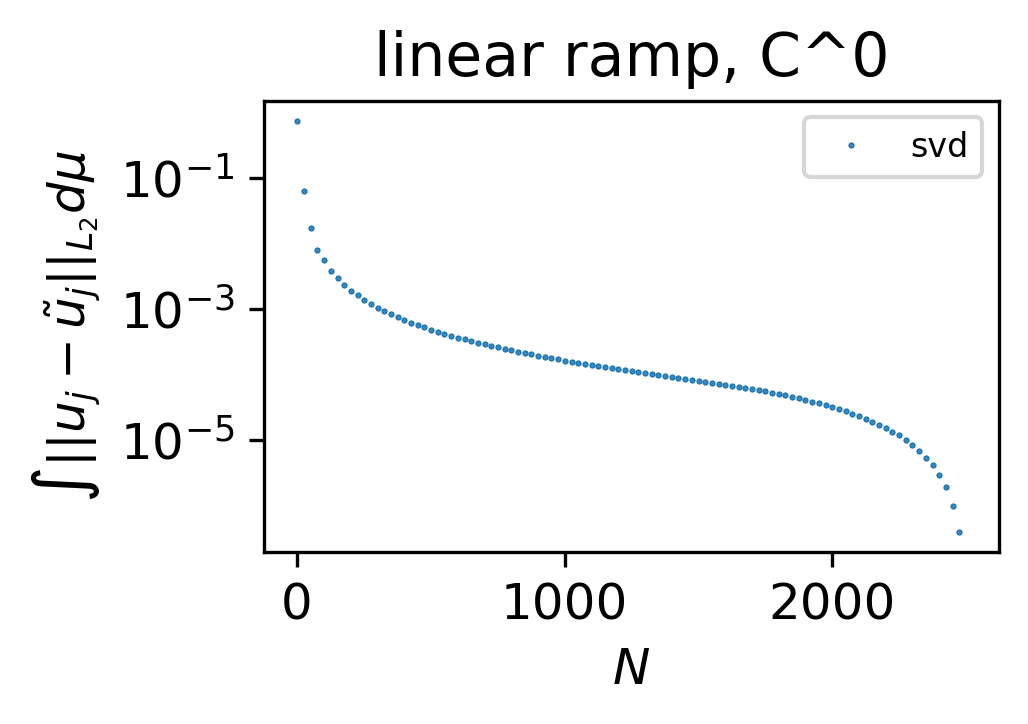

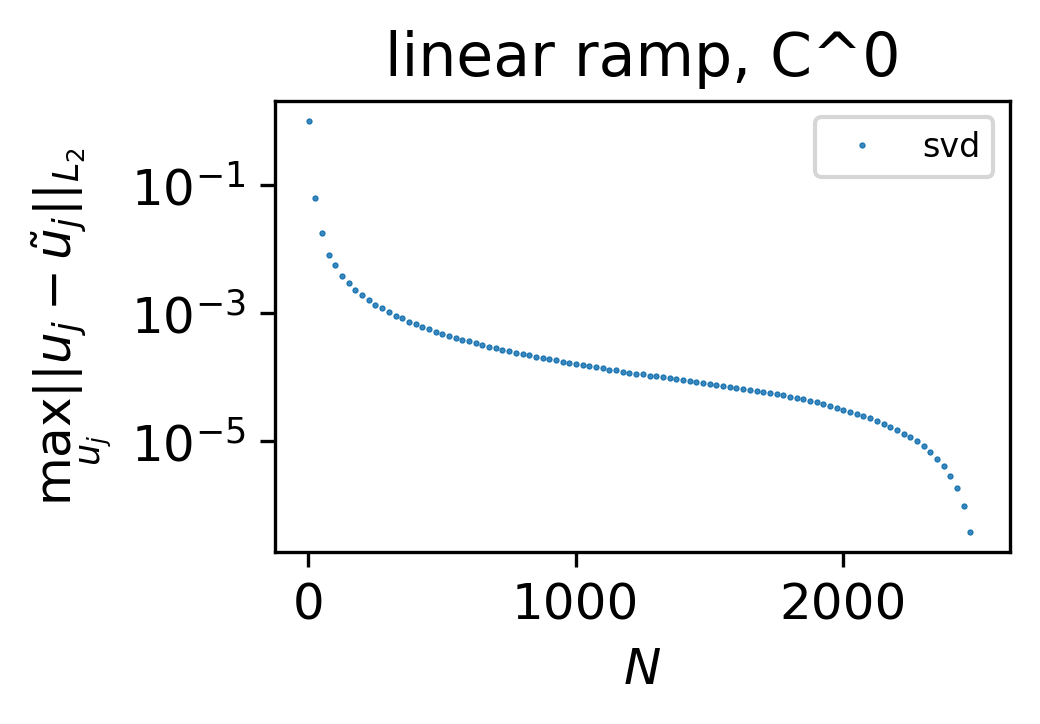

smooth ramp, C^1
$smooth ramp, C^1$
$\int_E_n(u(\mu;x)) d\mu$


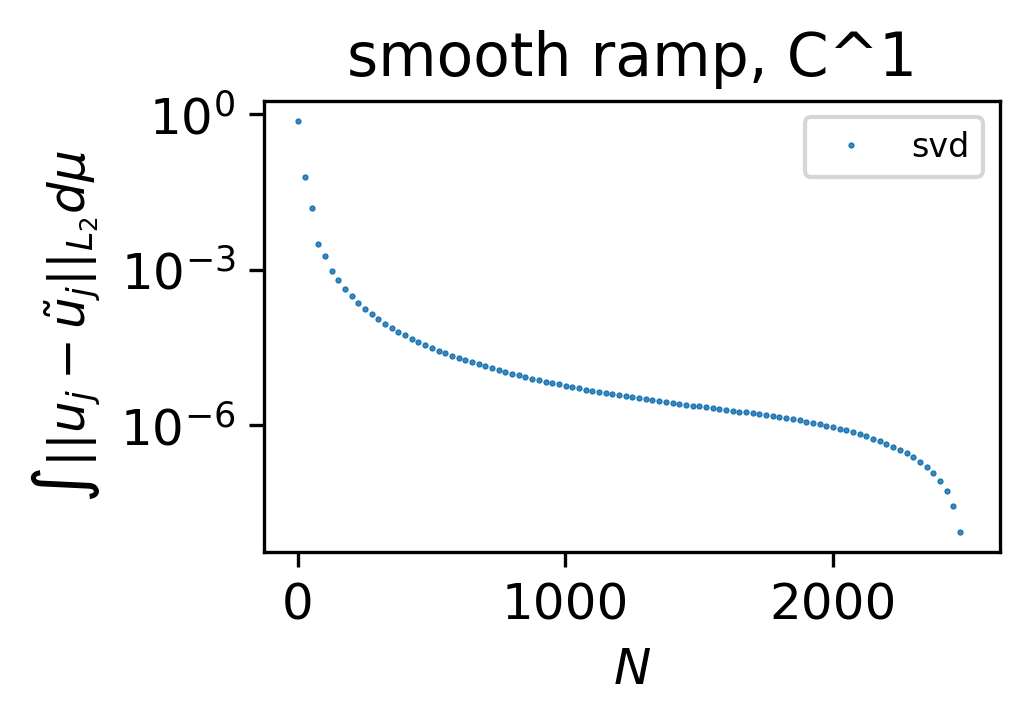

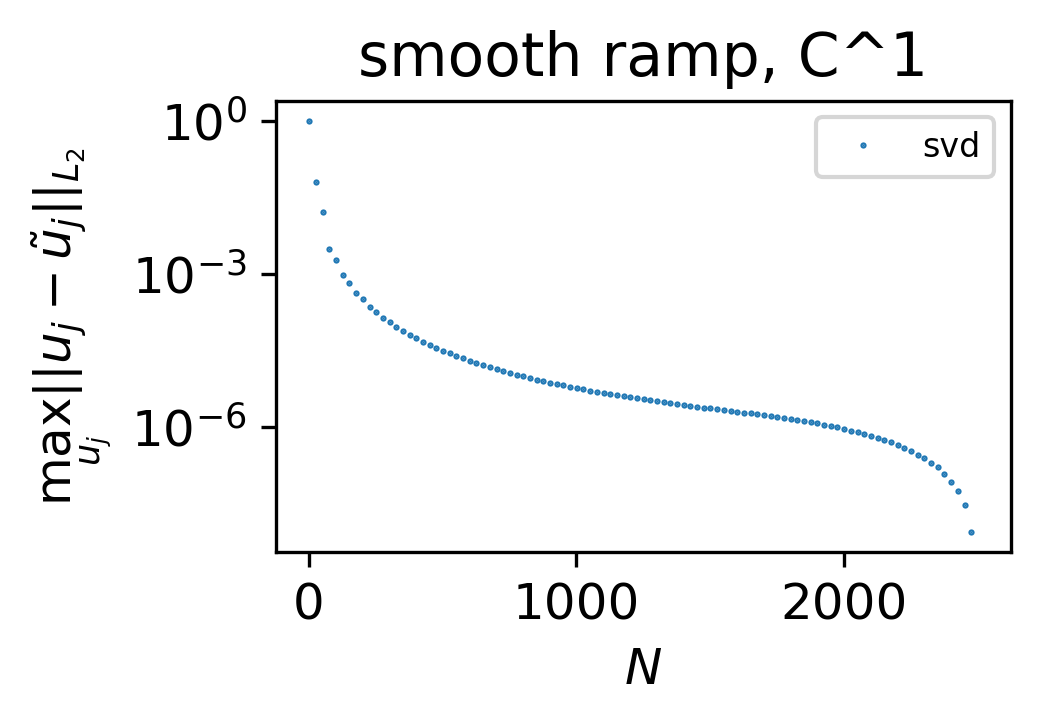

smooth ramp, C^2
$smooth ramp, C^2$
$\int_E_n(u(\mu;x)) d\mu$


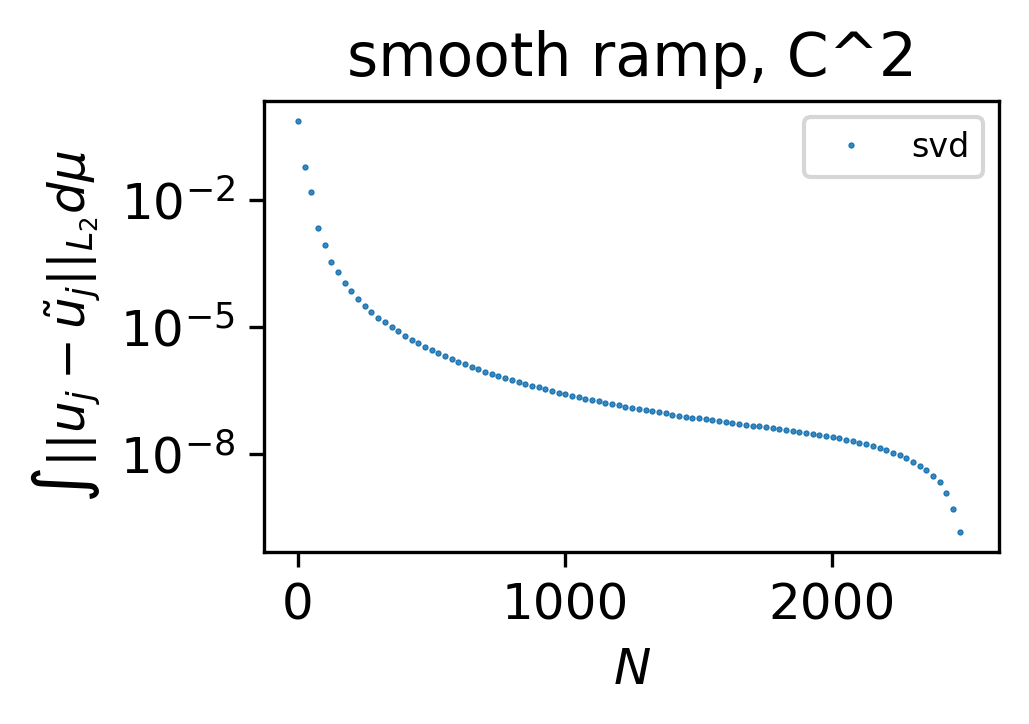

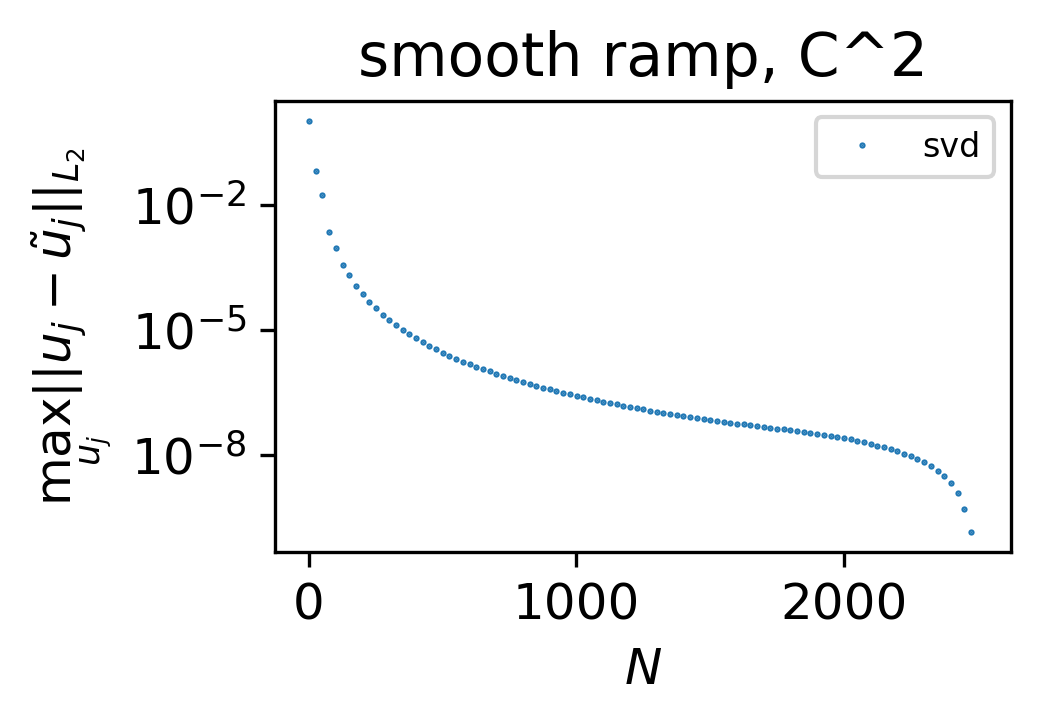

smooth ramp, C^3
$smooth ramp, C^3$
$\int_E_n(u(\mu;x)) d\mu$


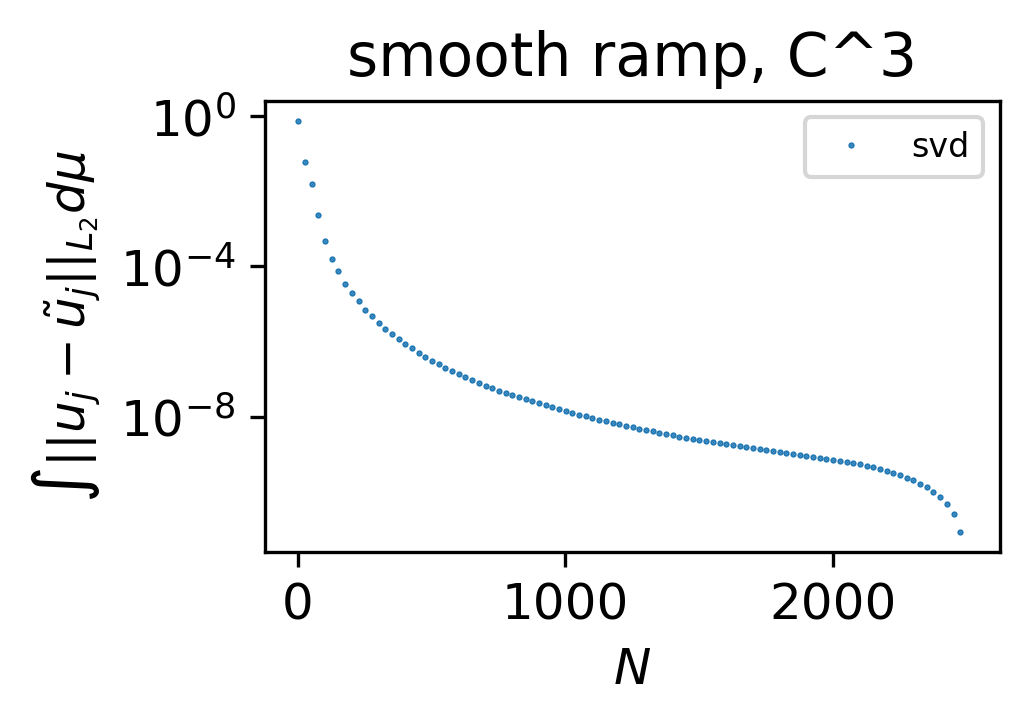

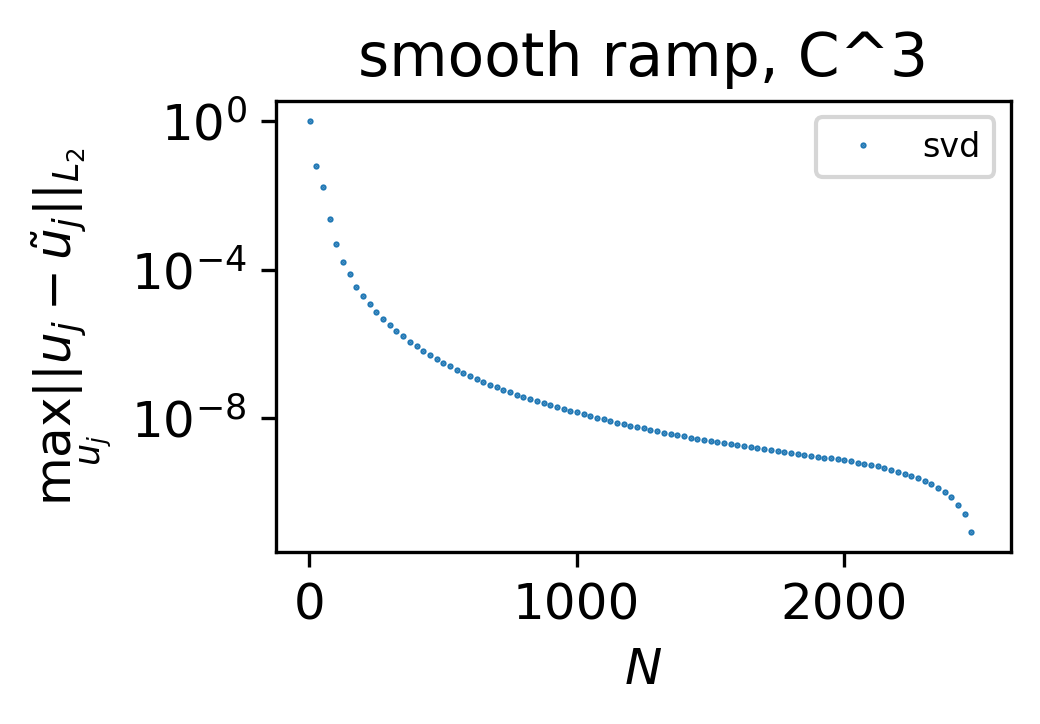

smooth ramp, C^4
$smooth ramp, C^4$
$\int_E_n(u(\mu;x)) d\mu$


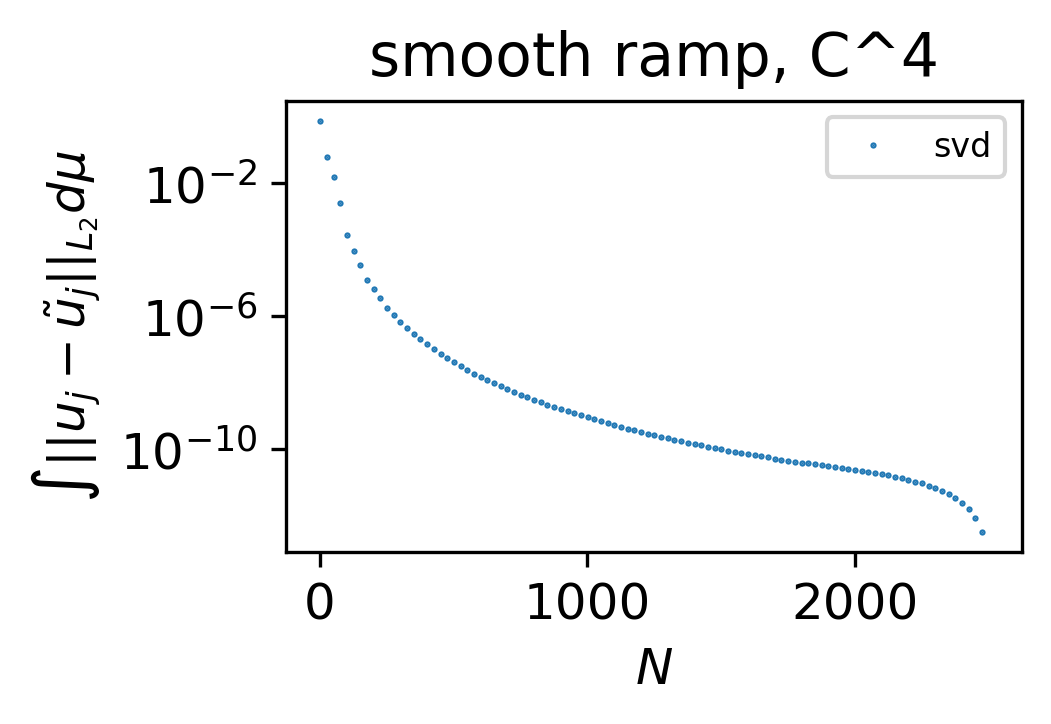

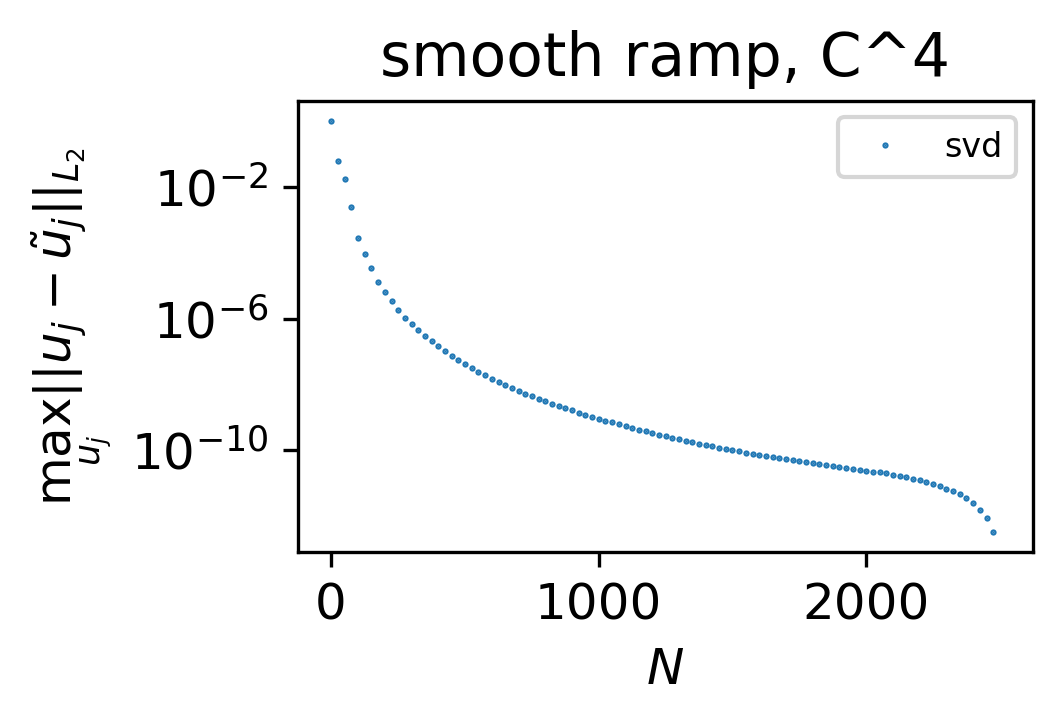

smooth ramp, C^5
$smooth ramp, C^5$
$\int_E_n(u(\mu;x)) d\mu$


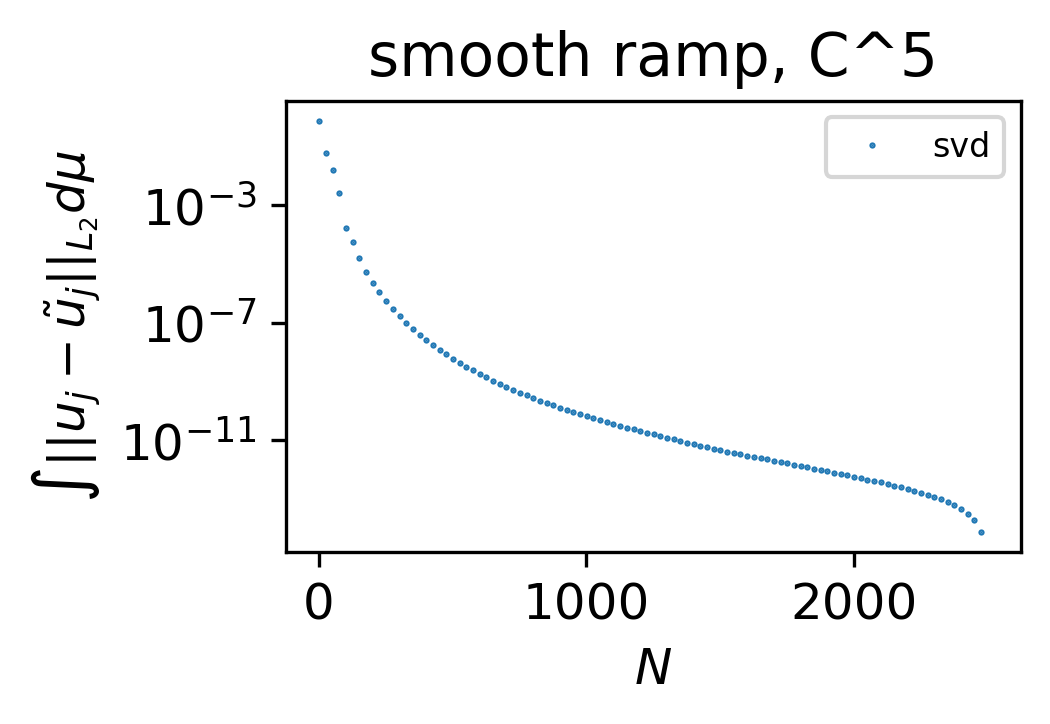

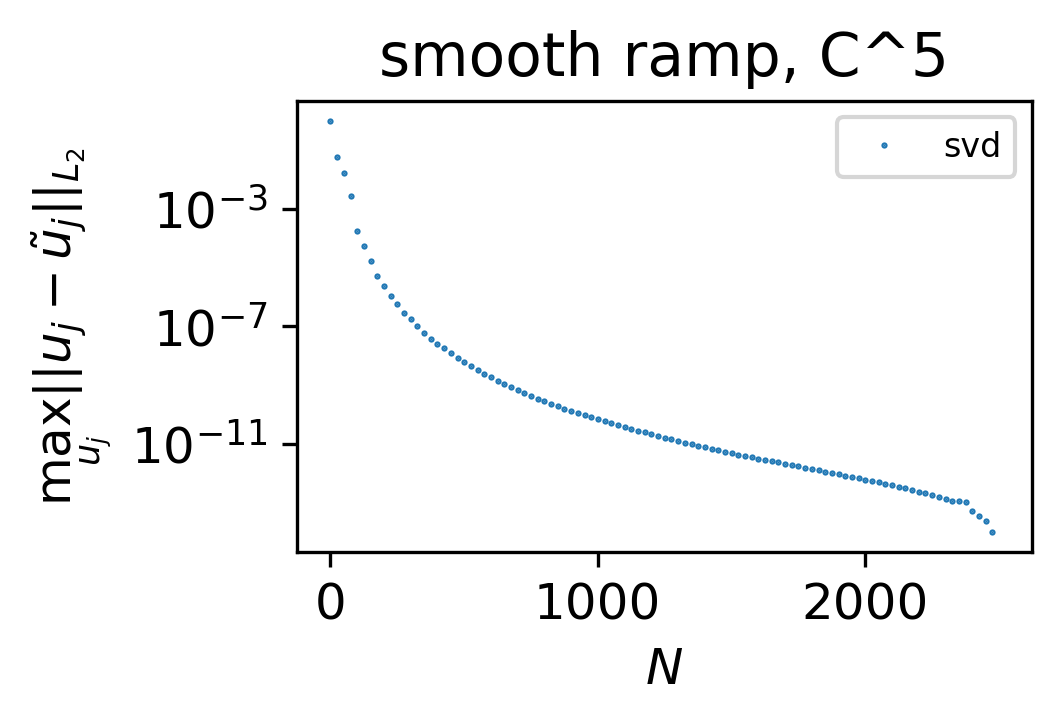

sigmoid (sin)
$sigmoid (sin)$
$\int_E_n(u(\mu;x)) d\mu$


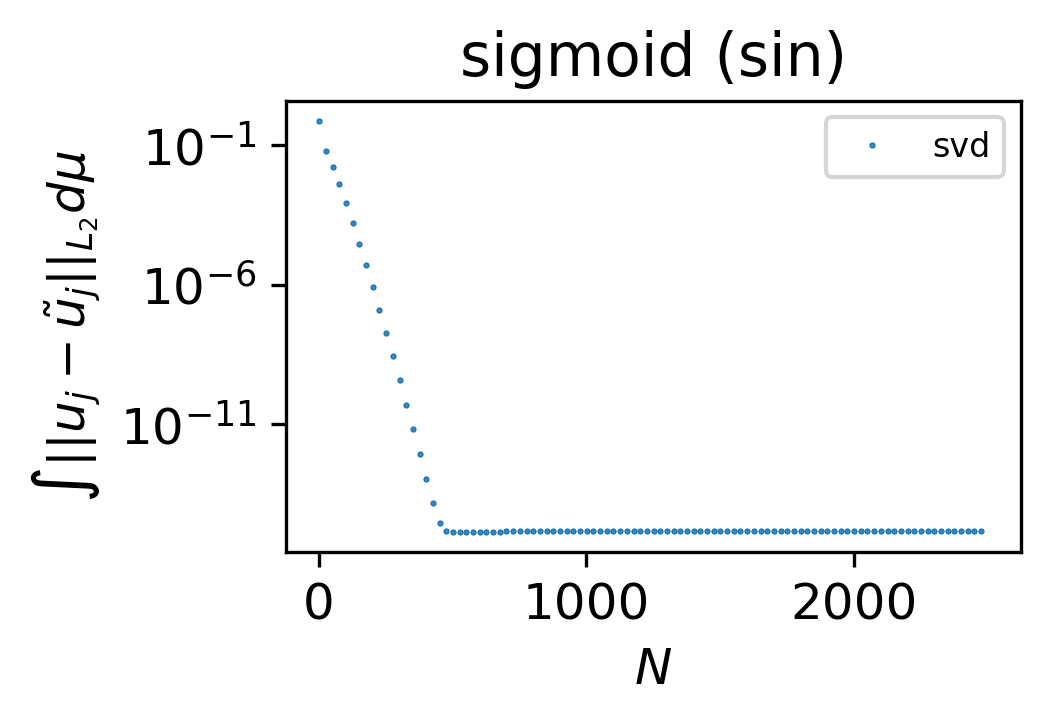

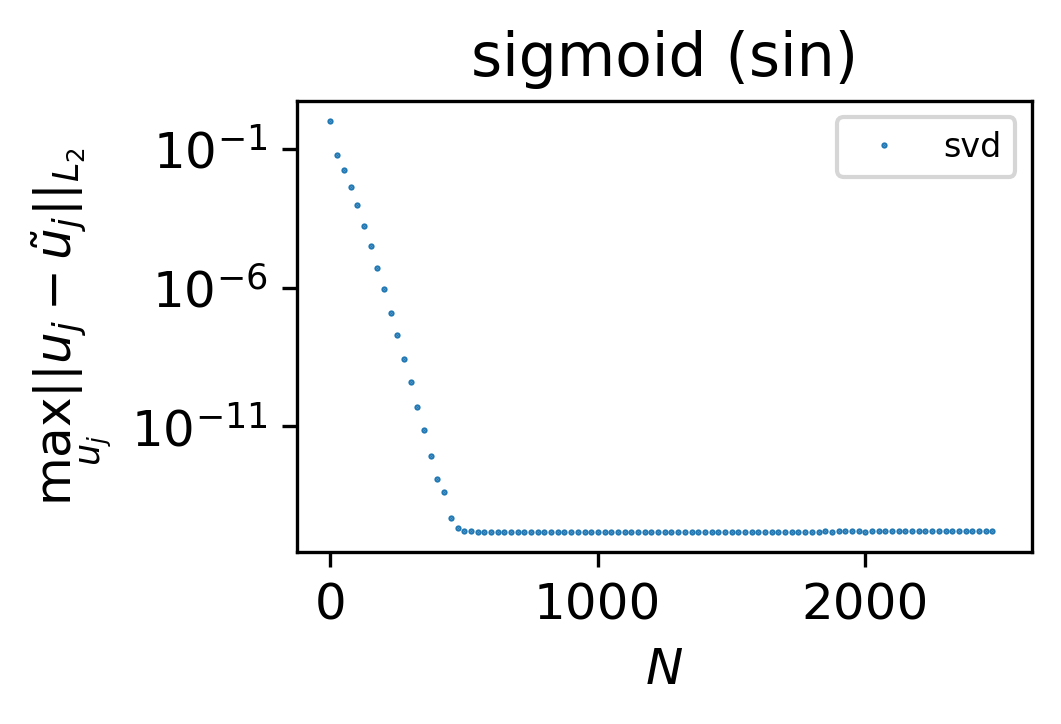

In [10]:
for j, ic in enumerate(initc):
    print(ic.name)
    print(r'$'+ic.name+'$')
    print(r'$\int_E_n(u(\mu;x)) d\mu$')
    
    fig, ax = plt.subplots()
    for i, bv in enumerate(basis_all):
        ax.plot(results[i][j][0], ".", ms=1, label=bv.name)
    ax.set_yscale('log')
    plt.title(ic.name)
    plt.legend(prop={'size': 8})
    plt.xlabel(r'$N$')
    plt.ylabel(r'$\int || u_j - \tilde{u}_j ||_{L_2} d\mu$')
    plt.show()
    
    fig, ax = plt.subplots()
    for i, bv in enumerate(basis_all):
        ax.plot(results[i][j][1], ".", ms=1, label=bv.name)
    ax.set_yscale('log')
    plt.title(ic.name)
    plt.legend(prop={'size': 8})
    plt.xlabel(r'$N$')
    plt.ylabel(r'$\max_{u_j} || u_j - \tilde{u}_j ||_{L_2} $')
    plt.show()
    

NameError: name 'sigma' is not defined

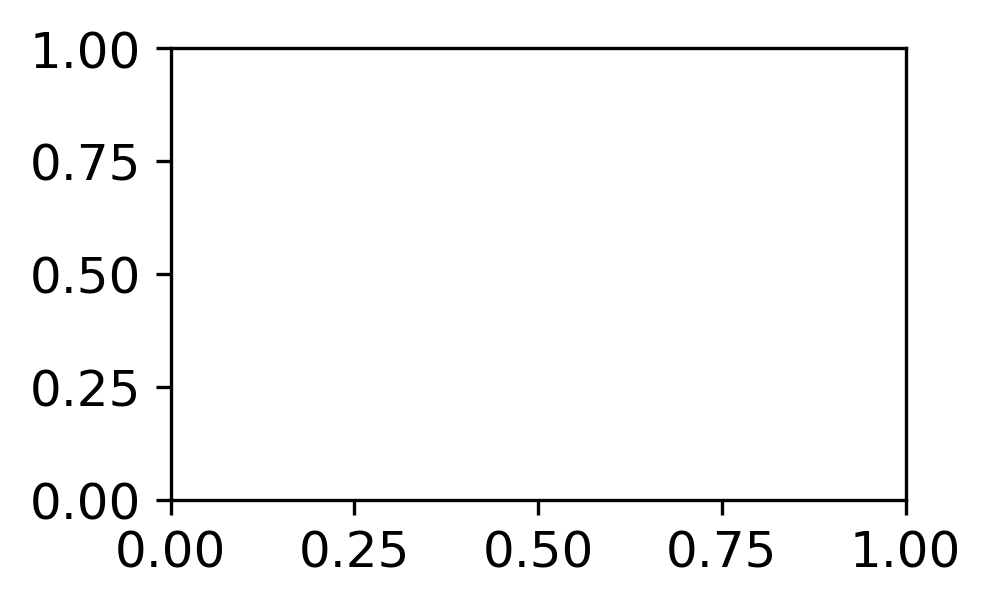

In [11]:
for j, ic in enumerate(initc):
    lbl = ic.name[:-3]+'$'+ic.name[-3:]+'$' if ic.name[-1].isdigit() else ic.name
    if lbl == "heaviside":
        print(lbl)
        sigma = results[0][j][0]
        

lbl1 = r'$2*\sqrt {\left( \frac{2}{N \pi^2} \right)}$'
lbl2 =  r'$2*\sqrt {\left( \frac{1}{2} - \frac{4}{\pi^2} \sum_{i=1}^N  \frac{1}{(2i-1)^2 } \right)}$'
lbl3 =  r'$\sqrt {\left(  \sum_{k=N+1}^\infty  \frac{8}{(2k-1)^2 \pi^2} \right)}$'
i = np.arange(1, 500)
N = np.arange(0, r)
decay_exact_old = 2*(1/2 - 4/np.pi**2*np.cumsum(1/(2*i-1)**2))**.5
decay_estimate = 2*(2/(i*np.pi**2))**.5

N_inf = np.arange(10000)
t = 8/ ((2*N_inf-1)**2*np.pi**2 )
res = np.cumsum(t[::-1])[::-1]
decay_new = res[N]**.5
        
fig, ax = plt.subplots()
ax.plot(N, sigma, "ro", ms=2, label="POD-ROM")

ax.plot(i, decay_exact_old, "g--", label=lbl2, lw=1)
ax.plot(i, decay_estimate, "b--", label=lbl1, lw=1)
ax.plot(N, decay_new, "k--", label=lbl3, lw=1)
ax.set_ylim([1e-2, 1])
ax.set_xlim([0, 500]) 
ax.set_yscale('log')
ax.legend(prop={'size': 6})
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\int || u_j - \tilde{u}_j ||_{L_2} d\mu$')
plt.show()

(6, 9, 4, 2500)
linear ramp, $C^0$
12.47622017243837 3.4641016151377544
smooth ramp, $C^1$
1102.464198596705 4.47213595499958
smooth ramp, $C^2$
156138.9580323958 5.291502622129181
smooth ramp, $C^3$
27685052.70657409 6.0
smooth ramp, $C^4$
5697424042.586072 6.6332495807108
smooth ramp, $C^5$
1312673608511.5037 7.211102550927978
sigmoid (sin)


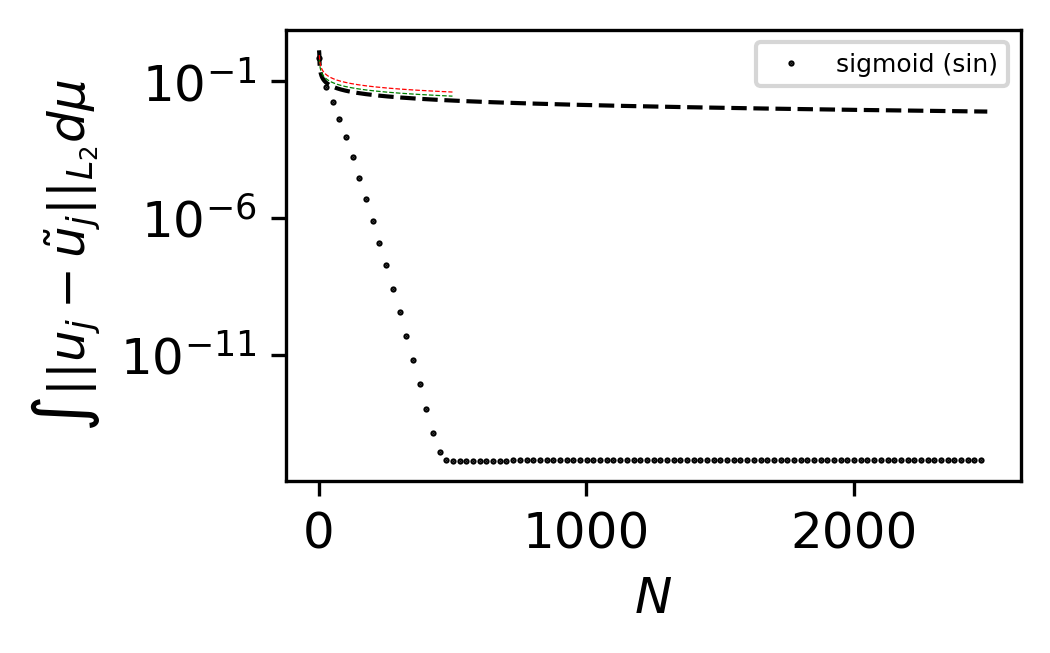

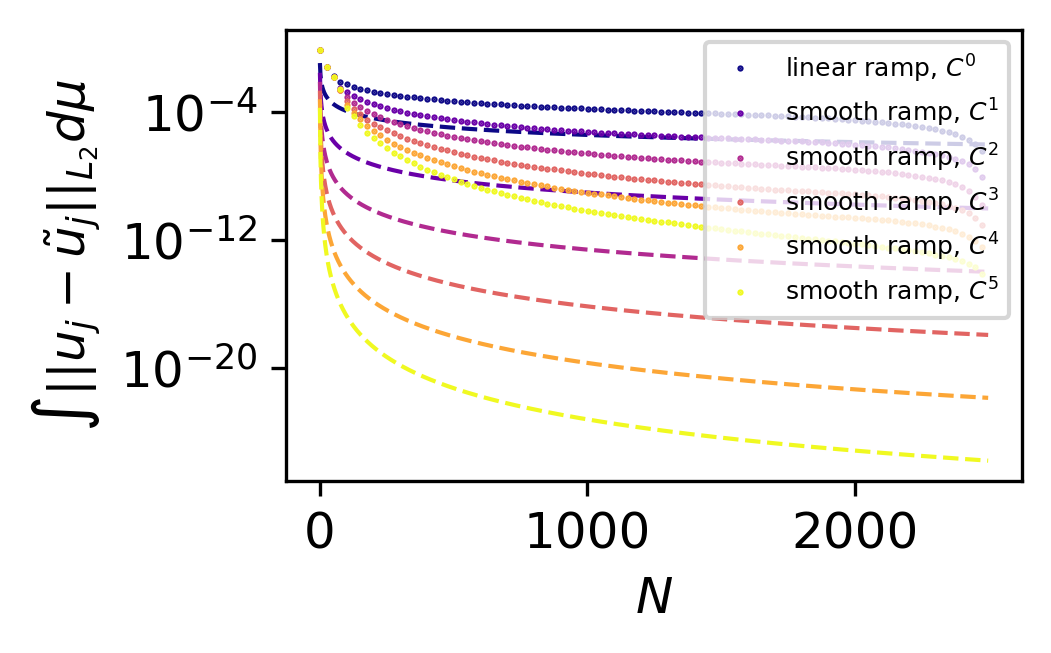

In [14]:
# np.save("C:/Users/florianma/Dropbox/Kol-N-width-Oslo-Ulm/data.npy", results)
i = 0
print(results.shape)

def L2(y, n):
    dy = np.diff(y.ravel(), n=n) * len(y)**n
    if n < -10:
        fig, ax = plt.subplots()
        plt.plot(dy)
        plt.show()
    return np.mean(dy**2)**.5


def model(N, c, y):
    if c == -1:
        # example 4.6: exact error
        N_inf = np.arange(10000)
        t = 8/ ((2*N_inf-1)**2*np.pi**2 )
        res = np.cumsum(t[::-1])[::-1]
        res = res[N]
        return res ** .5
    f_L2 = L2(y, c+1)
    if c<10:
        print(f_L2, 2*(2*k+3)**.5)
        
        Ninf = np.arange(1, 10000)
        #r = np.cumsum((4*(1/((2*np.floor((Ninf+1)/2)-1)*np.pi))**(2*k+4))[::-1])[::-1][N]**.5
#        r = f_L2 * 2*(2*k+3)**.5 / np.pi**(k+2) * N**(-(k+1.5)) # Theorem 6.2 upper bound
        r = 2/(2*k+3)**.5 / np.pi**(k+2) * (N+1)**(-(k+1.5)) # Theorem 6.2 lower bound
        #r = f_L2/np.pi**(k+1)*N**(-(k+1)/1.0)  # theorem 5.4: upper bound
        #print(f_L2/np.pi**(k+1), -(k+1)/2.0)
        return r
    else:
        res = np.zeros(N.shape)
        for N_ in N:
            f_n_L2 = 2*L2(y, N_)  # N-th derivative!
            #print(N_, f_n_L2)
            res[N_] = f_n_L2/np.pi**N_ * N_**(-N_/1.0)
        return res

def grenze(N, n, c):
    return c * N** (-(2*n+3)/2)
    #return 1/np.pi**(n+1) * (N-1)** (-(n+1)/2)

N = np.arange(0, r)
ks = [0, 1, 2, 3, 4, 5, -1, 10]
fig, ax1 = plt.subplots()
fig, ax2 = plt.subplots()
for j, ic in enumerate(initc):
    lbl = ic.name[:-3]+'$'+ic.name[-3:]+'$' if ic.name[-1].isdigit() else ic.name
    print(lbl)
    k = ks[j]
    sigma = results[i][j][0]
    #sigma_log = np.log10(sigma)
    #l = (sigma>0) & (N>50)
    if j > 5:
        color = "k"
        ax = ax1
    else:
        ax = ax2
        color = cmap(j/5)
    ax.plot(N, sigma, ".", ms=1, color=color, label=lbl)
    y = ic.half_wave_odd(np.linspace(0,1, 500), np.array([0.5])).ravel()
    m = model(N, k, y) # * 1/20
    ax.plot(N, m, "--", color=color, lw=1)
for ax in [ax1, ax2]:
    #ax.set_ylim([1e-2, 1])
    #ax.set_xlim([0, 500]) 
    ax.set_yscale('log')
    ax.legend(prop={'size': 6})
    ax.set_xlabel(r'$N$')
    ax.set_ylabel(r'$\int || u_j - \tilde{u}_j ||_{L_2} d\mu$')
# decay HS:
i = np.arange(1, 500)
decay_exact_old = 2*(1/2 - 4/np.pi**2*np.cumsum(1/(2*i-1)**2))**.5
decay_estimate = 2*(2/(i*np.pi**2))**.5
ax1.plot(i, decay_exact_old, "g--", lw=.3)
ax1.plot(i, decay_estimate, "r--", lw=.3)
plt.show()

svd


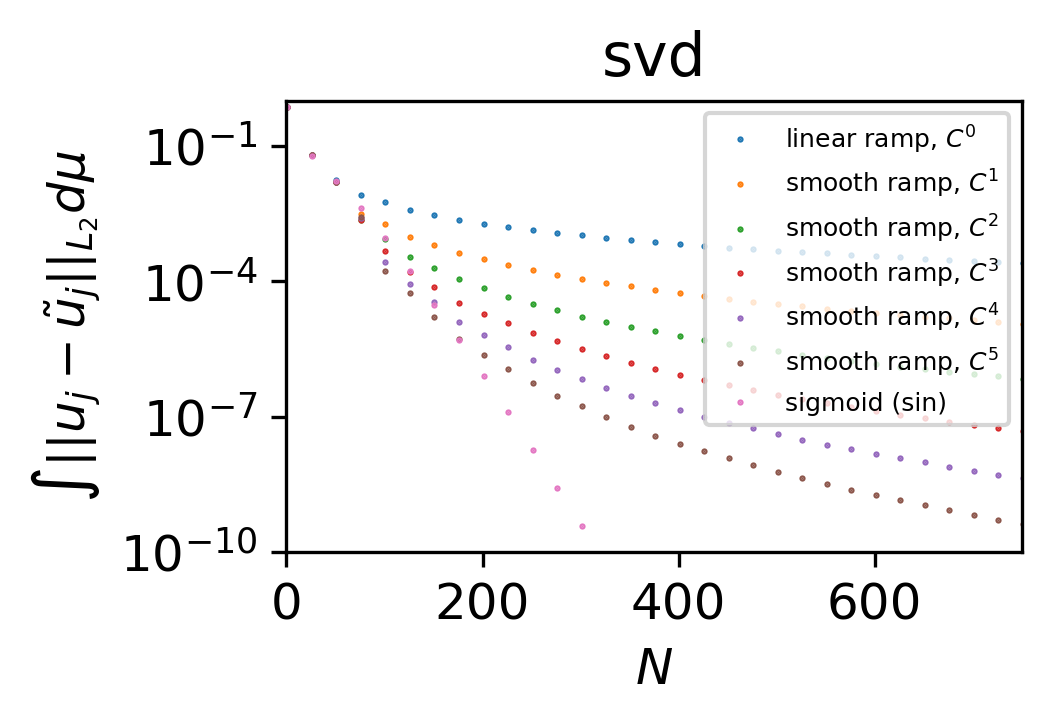

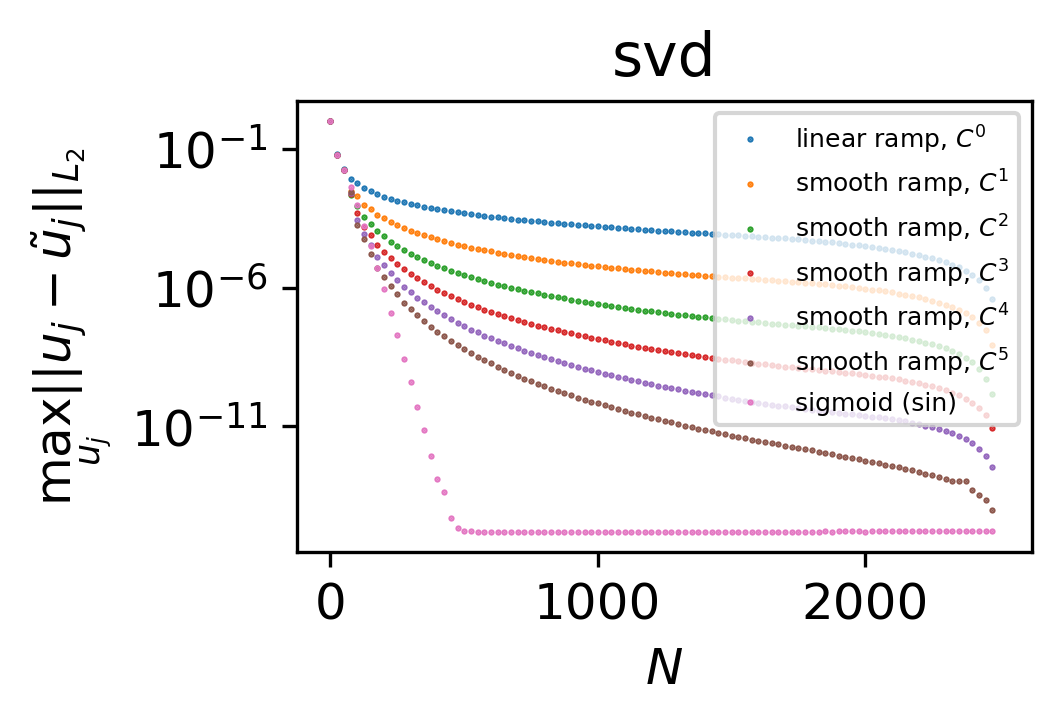

In [13]:
for i, bv in enumerate(basis_all):
    print(bv.name)
    
    fig, ax = plt.subplots()
    for j, ic in enumerate(initc):
        lbl = ic.name
        if ic.name[-1].isdigit():
            lbl = ic.name[:-3]+'$'+ic.name[-3:]+'$'
        ax.plot(results[i][j][0], ".", ms=1, label=lbl)
    ax.set_yscale('log')
    #N = np.arange(500)
    #for c in np.arange(6):
    #    estimate = 1/np.pi**(c+1) * (N-1)**(-(c+1)/2)
    #    ax.plot(N, estimate, "k--", lw=1)
    plt.title(bv.name)
    plt.legend(prop={'size': 6})
    plt.xlabel(r'$N$')
    plt.xlim([0, 750])
    plt.ylim([1e-10, 1])
    plt.ylabel(r'$\int || u_j - \tilde{u}_j ||_{L_2} d\mu$')
    plt.show()
    
    fig, ax = plt.subplots()
    for j, ic in enumerate(initc):
        lbl = ic.name
        if ic.name[-1].isdigit():
            lbl = ic.name[:-3]+'$'+ic.name[-3:]+'$'
        ax.plot(results[i][j][1], ".", ms=1, label=lbl)
    ax.set_yscale('log')
    plt.title(bv.name)
    plt.legend(prop={'size': 6})
    plt.xlabel(r'$N$')
    plt.ylabel(r'$\max_{u_j} || u_j - \tilde{u}_j ||_{L_2} $')
    plt.show()

In [ ]:
fig, ax = plt.subplots()
for i in [450]:
    plt.plot(x(), X[:, i])
plt.grid()
plt.show()
fig, ax = plt.subplots()
for i in [0, 1250, 1500, 1999]:
    plt.plot(x(), X[:, i])
plt.show()

In [ ]:
mu_plot = np.array([0, .25, .5, 0.75, 1])
X = u_k.half_half_wave_odd(x(), mu_plot)
# [-inf ... -1.0]:  g(x) = 0.0
# [-1.0 ... -0.5]:  g(x) = -f(x)
# [-0.5 ... -0.0]:  g(x) = -(1-f(x))
#  [0.0 ...  0.5]:  g(x) = f(x)
#  [0.5 ...  1.0]:  g(x) = 1-f(x)
#  [1.0 ...  inf]:  g(x) = 0.0

In [ ]:
i = 250
for i, xx in enumerate(mu_plot):
    T = 2
    #xx = mu()[i]
    fig, ax = plt.subplots()
    plt.plot(x(), X[:, i])
    plt.plot([xx, xx], [-1, 1], "r--", label="x=mu")
    plt.plot([xx-T/8, xx-T/8], [-1, 1], "k--", lw=.5, label="original intervall")
    plt.plot([xx+T/8, xx+T/8], [-1, 1], "k--", lw=.5)
    for j in [1, 3, 5, 7, 9, 11, 13]:
        plt.plot([xx+T*j/8, xx+T*j/8], [-1, 1], "k--", lw=.5)
        plt.plot([xx-T*j/8, xx-T*j/8], [-1, 1], "k--", lw=.5)
    plt.plot([xx+T/4, xx+T/4], [-1, 1], "g--")
    plt.plot([xx+T/2, xx+T/2], [-1, 1], "b--")
    plt.plot([xx-T/4, xx-T/4], [-1, 1], "g--", label="mu+-T/4")
    plt.plot([xx-T/2, xx-T/2], [-1, 1], "b--", label="mu+-T/2")
    plt.xlim([-1, 1])
    plt.legend(prop={'size': 6})
    plt.grid()



In [ ]:
i = 250
for i, xx in enumerate(mu_plot):
    T = 2
    #xx = mu()[i]
    fig, ax = plt.subplots()
    plt.plot(x(), X[:, i])
    plt.plot([xx, xx], [-1, 1], "r--", label="x=mu")
    plt.plot([xx-T/4, xx-T/4], [-1, 1], "g--", label="Naht")
    plt.plot([xx-T/2, xx-T/2], [-1, 1], "b--", label="x=mu-1")
    plt.xlim([-.1, 1.1])
    plt.legend(prop={'size': 6})
    plt.grid()